In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from catboost import cv as catboost_cv

from sklearn.model_selection import (
    TimeSeriesSplit, train_test_split, cross_val_score,
    cross_validate, StratifiedKFold
)

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    roc_auc_score, f1_score, precision_recall_curve,
    average_precision_score, PrecisionRecallDisplay, make_scorer
)

from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectFromModel
from itertools import combinations
from ast import literal_eval
from datetime import datetime


In [2]:
df_p = pd.read_csv('filtered_data/apparel-purchases.csv')
df_m = pd.read_csv('filtered_data/apparel-messages.csv')
df_t = pd.read_csv('filtered_data/apparel-target_binary.csv')

In [3]:
display(df_p.info())
display(df_p.head(7))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


None

client_id  quantity   price                category_ids  \
0  1515915625468169594         1  1999.0    ['4', '28', '57', '431']   
1  1515915625468169594         1  2499.0    ['4', '28', '57', '431']   
2  1515915625471138230         1  6499.0    ['4', '28', '57', '431']   
3  1515915625471138230         1  4999.0   ['4', '28', '244', '432']   
4  1515915625471138230         1  4999.0    ['4', '28', '49', '413']   
5  1515915625471640575         1  3499.0   ['2', '18', '258', '441']   
6  1515915625490211585         1  1699.0  ['2', '18', '341', '1311']   

         date                              message_id  
0  2022-05-16  1515915625468169594-4301-627b661e9736d  
1  2022-05-16  1515915625468169594-4301-627b661e9736d  
2  2022-05-16  1515915625471138230-4437-6282242f27843  
3  2022-05-16  1515915625471138230-4437-6282242f27843  
4  2022-05-16  1515915625471138230-4437-6282242f27843  
5  2022-05-16  1515915625471640575-4301-627b661b67ac3  
6  2022-05-16  1515915625490211585-4301-627b661843283

In [4]:
display(df_m.info())
display(df_m.head(7))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


None

bulk_campaign_id            client_id  \
0              4439  1515915625626736623   
1              4439  1515915625490086521   
2              4439  1515915625553578558   
3              4439  1515915625553578558   
4              4439  1515915625471518311   
5              4439  1515915625594606468   
6              4439  1515915625491810918   

                               message_id  event channel        date  \
0  1515915625626736623-4439-6283415ac07ea   open   email  2022-05-19   
1  1515915625490086521-4439-62834150016dd   open   email  2022-05-19   
2  1515915625553578558-4439-6283415b36b4f   open   email  2022-05-19   
3  1515915625553578558-4439-6283415b36b4f  click   email  2022-05-19   
4  1515915625471518311-4439-628341570c133   open   email  2022-05-19   
5  1515915625594606468-4439-6283411f277fc   open   email  2022-05-19   
6  1515915625491810918-4439-6283411d9d299   open   email  2022-05-19   

            created_at  
0  2022-05-19 00:14:20  
1  2022-05-19 00:39:34  
2  2022-05-19 00:51:49  
3  2022-05-19 00:52:20  
4  2022-05-19 00:56:52  
5  2022-05-19 01:04:11  
6  2022-05-19 01:19:54

In [5]:
display(df_t.info())
display(df_t.head(7))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


None

client_id  target
0  1515915625468060902       0
1  1515915625468061003       1
2  1515915625468061099       0
3  1515915625468061100       0
4  1515915625468061170       0
5  1515915625468061514       0
6  1515915625468061877       0

In [6]:
# –ú–æ–∂–Ω–æ –¥–æ–±–∞–≤–∏—Ç—å –ø—Ä–æ–≤–µ—Ä–∫—É –Ω–∞ —É–Ω–∏–∫–∞–ª—å–Ω–æ—Å—Ç—å –∫–ª—é—á–µ–π –ø–µ—Ä–µ–¥ –æ–±—ä–µ–¥–∏–Ω–µ–Ω–∏–µ–º
print(df_p[['client_id', 'message_id']].duplicated().sum())
print(df_m[['client_id', 'message_id']].duplicated().sum())

143876
3678131


In [7]:
df_pm = df_p.merge(df_m, on=['client_id', 'message_id'], how='inner', suffixes=('_purchase', '_message'))
df_pm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805820 entries, 0 to 805819
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         805820 non-null  int64  
 1   quantity          805820 non-null  int64  
 2   price             805820 non-null  float64
 3   category_ids      805820 non-null  object 
 4   date_purchase     805820 non-null  object 
 5   message_id        805820 non-null  object 
 6   bulk_campaign_id  805820 non-null  int64  
 7   event             805820 non-null  object 
 8   channel           805820 non-null  object 
 9   date_message      805820 non-null  object 
 10  created_at        805820 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 67.6+ MB


In [8]:
print(len(df_pm[~df_pm['client_id'].isin(df_t['client_id'])]))

0


In [9]:
df = df_pm.merge(df_t, on='client_id', how='inner')
display(df.info())
display(df.sample(8))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805820 entries, 0 to 805819
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         805820 non-null  int64  
 1   quantity          805820 non-null  int64  
 2   price             805820 non-null  float64
 3   category_ids      805820 non-null  object 
 4   date_purchase     805820 non-null  object 
 5   message_id        805820 non-null  object 
 6   bulk_campaign_id  805820 non-null  int64  
 7   event             805820 non-null  object 
 8   channel           805820 non-null  object 
 9   date_message      805820 non-null  object 
 10  created_at        805820 non-null  object 
 11  target            805820 non-null  int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 73.8+ MB


None

client_id  quantity   price  \
480652  1515915625566783209         1  3299.0   
397607  1515915625489165229         1  1399.0   
288687  1515915625650382844         1  1354.0   
646890  1515915625488913440         1   159.0   
201428  1515915625815832152         1  1299.0   
467127  1515915625488354080         1     1.0   
651016  1515915625559931867         1   299.0   
467730  1515915625489552555         1   400.0   

                            category_ids date_purchase  \
480652         ['4', '28', '146', '548']    2023-04-28   
397607   ['5562', '5631', '5549', '667']    2023-03-11   
288687  ['5562', '5589', '5563', '1811']    2022-11-18   
646890  ['6060', '6058', '6065', '5499']    2023-07-28   
201428         ['4', '28', '104', '429']    2022-09-09   
467127   ['5562', '5536', '5656', '614']    2023-04-22   
651016   ['5562', '5633', '5578', '700']    2023-08-05   
467730         ['4', '28', '290', '422']    2023-04-23   

                                     message_id  bulk_campaign_id     event  \
480652  1515915625566783209-12218-644b837cb2a1f             12218      open   
397607  1515915625489165229-10792-640ad92f0ece1             10792     click   
288687   1515915625650382844-7930-63764578d7061              7930      send   
646890  1515915625488913440-13564-64c368e623290             13564  purchase   
201428   1515915625815832152-6289-631ada3b7a5cf              6289     click   
467127  1515915625488354080-11952-643e791820213             11952     click   
651016  1515915625559931867-13598-64cd08c473b82             13598  purchase   
467730  1515915625489552555-11855-643932ee8d4a7             11855  purchase   

            channel date_message           created_at  target  
480652        email   2023-04-28  2023-04-28 18:48:55       0  
397607        email   2023-03-10  2023-03-10 08:01:34       0  
288687  mobile_push   2022-11-17  2022-11-17 14:39:13       0  
646890        email   2023-07-28  2023-07-28 07:40:57       0  
201428        email   2022-09-09  2022-09-09 11:10:12       0  
467127        email   2023-04-20  2023-04-20 12:19:36       0  
651016  mobile_push   2023-08-05  2023-08-05 07:59:16       0  
467730        email   2023-04-23  2023-04-23 18:55:30       0

# –ü—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∞ –¥–∞–Ω–Ω—ã—Ö

In [11]:
# –ö–ê–¢–ï–ì–û–†–ò–ê–õ–¨–ù–´–ï
df['event'] = df['event'].astype('category')
df['channel'] = df['channel'].astype('category')

# –î–ê–¢–´ 
df['date_purchase'] = pd.to_datetime(df['date_purchase'], format='%Y-%m-%d', errors='coerce')
df['date_message'] = pd.to_datetime(df['date_message'], format='%Y-%m-%d', errors='coerce')
df['created_at'] = pd.to_datetime(df['created_at'], format='%Y-%m-%d %H:%M:%S', errors='coerce')


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805820 entries, 0 to 805819
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         805820 non-null  int64         
 1   quantity          805820 non-null  int64         
 2   price             805820 non-null  float64       
 3   category_ids      805820 non-null  object        
 4   date_purchase     805820 non-null  datetime64[ns]
 5   message_id        805820 non-null  object        
 6   bulk_campaign_id  805820 non-null  int64         
 7   event             805820 non-null  category      
 8   channel           805820 non-null  category      
 9   date_message      805820 non-null  datetime64[ns]
 10  created_at        805820 non-null  datetime64[ns]
 11  target            805820 non-null  int64         
dtypes: category(2), datetime64[ns](3), float64(1), int64(4), object(2)
memory usage: 63.0+ MB


In [13]:
def preprocess_data(df):
    # ===== –û–±—Ä–∞–±–æ—Ç–∫–∞ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö =====
    cat_cols = ['event', 'channel']
    for col in cat_cols:
        df[col] = df[col].astype('category')
    
    # ===== –û–±—Ä–∞–±–æ—Ç–∫–∞ category_ids =====
    def safe_parse_categories(cat_str):
        try:
            categories = literal_eval(str(cat_str))
            return [int(c) for c in categories if c and str(c).isdigit()]
        except:
            return []
    
    # –°–æ–∑–¥–∞–µ–º –≤—Ä–µ–º–µ–Ω–Ω—ã–π —Å—Ç–æ–ª–±–µ—Ü —Å–æ —Å–ø–∏—Å–∫–∞–º–∏ –∫–∞—Ç–µ–≥–æ—Ä–∏–π
    df['_categories'] = df['category_ids'].apply(safe_parse_categories)
    
    # –ó–∞–º–µ–Ω—è–µ–º —Å–ø–∏—Å–∫–∏ –Ω–∞ —Ö–µ—à–∏ –¥–ª—è CatBoost
    df['categories_hash'] = df['_categories'].apply(lambda x: hash(tuple(x)) if x else 0)
    df['main_category'] = df['_categories'].apply(lambda x: x[0] if x else -1)
    df['num_categories'] = df['_categories'].apply(len)
    
    # –£–¥–∞–ª—è–µ–º –≤—Ä–µ–º–µ–Ω–Ω—ã–π —Å—Ç–æ–ª–±–µ—Ü
    df = df.drop(columns=['_categories', 'category_ids'])
    
    # ===== –û–ø—Ç–∏–º–∏–∑–∞—Ü–∏—è —Ç–∏–ø–æ–≤ –¥–∞–Ω–Ω—ã—Ö =====
    df['quantity'] = pd.to_numeric(df['quantity'], downcast='integer')
    df['bulk_campaign_id'] = pd.to_numeric(df['bulk_campaign_id'], downcast='integer')
    df['price'] = pd.to_numeric(df['price'], downcast='float')
    df['categories_hash'] = pd.to_numeric(df['categories_hash'], downcast='integer')
    
   # ===== –†–∞—Å—à–∏—Ä–µ–Ω–Ω–∞—è –æ–±—Ä–∞–±–æ—Ç–∫–∞ –¥–∞—Ç =====
    date_cols = {
        'date_purchase': '%Y-%m-%d',
        'date_message': '%Y-%m-%d', 
        'created_at': '%Y-%m-%d %H:%M:%S'
    }
    
    for col, fmt in date_cols.items():
        df[col] = pd.to_datetime(df[col], format=fmt, errors='coerce')
    
    # –£–¥–∞–ª–µ–Ω–∏–µ —Å—Ç—Ä–æ–∫ —Å –Ω–µ–∫–æ—Ä—Ä–µ–∫—Ç–Ω—ã–º–∏ –¥–∞—Ç–∞–º–∏
    df = df.dropna(subset=list(date_cols.keys()), how='any')
    
    # ===== –°–æ–∑–¥–∞–Ω–∏–µ –≤—Ä–µ–º–µ–Ω–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ =====
    current_date = datetime.now()
    
    df['days_since_purchase'] = (current_date - df['date_purchase']).dt.days
    df['days_since_message'] = (current_date - df['date_message']).dt.days
    df['purchase_to_message_days'] = (df['date_purchase'] - df['date_message']).dt.days
    
    # ===== –û–±—Ä–∞–±–æ—Ç–∫–∞ –ø—Ä–æ–ø—É—Å–∫–æ–≤ =====
    # –ó–∞–ø–æ–ª–Ω–µ–Ω–∏–µ –ø—Ä–æ–ø—É—Å–∫–æ–≤ –≤ –Ω–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–∞—Ö
    df['purchase_to_message_days'] = df['purchase_to_message_days'].fillna(0)
    
    # ===== –î–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã–µ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏—è =====
    # –ë–∏–Ω–∞—Ä–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –¥–ª—è —Å–æ–±—ã—Ç–∏–π
    df['is_click'] = (df['event'] == 'click').astype(int)
    df['is_open'] = (df['event'] == 'open').astype(int)
    
    # –û–ø—Ç–∏–º–∏–∑–∞—Ü–∏—è –ø–∞–º—è—Ç–∏
    df = optimize_memory(df)
    
    return df

def optimize_memory(df):
    """–û–ø—Ç–∏–º–∏–∑–∞—Ü–∏—è —Ç–∏–ø–æ–≤ –¥–∞–Ω–Ω—ã—Ö –¥–ª—è —É–º–µ–Ω—å—à–µ–Ω–∏—è –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è –ø–∞–º—è—Ç–∏"""
    # –û–ø—Ç–∏–º–∏–∑–∞—Ü–∏—è –∫–∞—Ç–µ–≥–æ—Ä–∏–π
    for col in df.select_dtypes(['category']):
        num_unique = df[col].nunique()
        if num_unique < 50:
            df[col] = df[col].cat.as_ordered()
    
    # –û–ø—Ç–∏–º–∏–∑–∞—Ü–∏—è —á–∏—Å–ª–æ–≤—ã—Ö —Ç–∏–ø–æ–≤
    int_cols = df.select_dtypes(['int64']).columns
    df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='integer')
    
    float_cols = df.select_dtypes(['float64']).columns
    df[float_cols] = df[float_cols].apply(pd.to_numeric, downcast='float')
    
    return df

df_processed = preprocess_data(df.copy())

print("\n–ü–æ—Å–ª–µ –ø—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∏:")
print(df_processed.info())
print("\n–ü—Ä–∏–º–µ—Ä –¥–∞–Ω–Ω—ã—Ö:")
print(df_processed.head(3))


–ü–æ—Å–ª–µ –ø—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∏:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805820 entries, 0 to 805819
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   client_id                 805820 non-null  int64         
 1   quantity                  805820 non-null  int8          
 2   price                     805820 non-null  float32       
 3   date_purchase             805820 non-null  datetime64[ns]
 4   message_id                805820 non-null  object        
 5   bulk_campaign_id          805820 non-null  int16         
 6   event                     805820 non-null  category      
 7   channel                   805820 non-null  category      
 8   date_message              805820 non-null  datetime64[ns]
 9   created_at                805820 non-null  datetime64[ns]
 10  target                    805820 non-null  int8          
 11  categories_hash          

### –ü—Ä–æ–º–µ–∂—É—Ç–æ—á–Ω—ã–π –≤—ã–≤–æ–¥ –ø–æ –ø—Ä–æ–¥–µ–ª–∞–Ω–Ω–æ–π —Ä–∞–±–æ—Ç–µ

–ù–∞ —Ç–µ–∫—É—â–µ–º —ç—Ç–∞–ø–µ –≤—ã–ø–æ–ª–Ω–µ–Ω–∞ –∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω–∞—è –ø–æ–¥–≥–æ—Ç–æ–≤–∏—Ç–µ–ª—å–Ω–∞—è —Ä–∞–±–æ—Ç–∞ –ø–æ –æ–±—Ä–∞–±–æ—Ç–∫–µ –∏ –∞–Ω–∞–ª–∏–∑—É –¥–∞–Ω–Ω—ã—Ö. –í–æ—Ç –∫–ª—é—á–µ–≤—ã–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã –∏ –Ω–∞–±–ª—é–¥–µ–Ω–∏—è:

1. **–û–±—ä–µ–¥–∏–Ω–µ–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö**:
   - –£—Å–ø–µ—à–Ω–æ –æ–±—ä–µ–¥–∏–Ω–µ–Ω—ã —Ç—Ä–∏ –∏—Å—Ç–æ—á–Ω–∏–∫–∞ –¥–∞–Ω–Ω—ã—Ö (`apparel-purchases`, `apparel-messages`, `apparel-target_binary`) –ø–æ –∫–ª—é—á–∞–º `client_id` –∏ `message_id`.
   - –ü—Ä–æ–≤–µ—Ä–∫–∞ –Ω–∞ –¥—É–±–ª–∏–∫–∞—Ç—ã –∏ –ø–µ—Ä–µ—Å–µ—á–µ–Ω–∏–µ –∫–ª–∏–µ–Ω—Ç–æ–≤ –ø–æ–∫–∞–∑–∞–ª–∞, —á—Ç–æ –≤—Å–µ –∫–ª–∏–µ–Ω—Ç—ã –∏–∑ –æ–±—ä–µ–¥–∏–Ω–µ–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö –ø—Ä–∏—Å—É—Ç—Å—Ç–≤—É—é—Ç –≤ —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π.

2. **–ü—Ä–µ–¥–≤–∞—Ä–∏—Ç–µ–ª—å–Ω—ã–π –∞–Ω–∞–ª–∏–∑ –¥–∞–Ω–Ω—ã—Ö**:
   - –ò—Å—Ö–æ–¥–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ —Å–æ–¥–µ—Ä–∂–∞—Ç –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—é –æ –ø–æ–∫—É–ø–∫–∞—Ö (—Ü–µ–Ω–∞, –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ, –∫–∞—Ç–µ–≥–æ—Ä–∏–∏), –º–∞—Ä–∫–µ—Ç–∏–Ω–≥–æ–≤—ã—Ö —Å–æ–æ–±—â–µ–Ω–∏—è—Ö (–∫–∞–Ω–∞–ª, —Å–æ–±—ã—Ç–∏–µ) –∏ —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π (–±–∏–Ω–∞—Ä–Ω—ã–π —Ñ–ª–∞–≥).
   - –û–±–Ω–∞—Ä—É–∂–µ–Ω—ã –∏ –æ–±—Ä–∞–±–æ—Ç–∞–Ω—ã –¥—É–±–ª–∏–∫–∞—Ç—ã –≤ –¥–∞–Ω–Ω—ã—Ö –ø–µ—Ä–µ–¥ –æ–±—ä–µ–¥–∏–Ω–µ–Ω–∏–µ–º.

3. **–ü—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∞ –¥–∞–Ω–Ω—ã—Ö**:
   - –ö–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ (`event`, `channel`) –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω—ã –≤ —Ç–∏–ø `category` –¥–ª—è –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–∏ –ø–∞–º—è—Ç–∏.
   - –ü–æ–ª—è —Å –¥–∞—Ç–∞–º–∏ –ø—Ä–∏–≤–µ–¥–µ–Ω—ã –∫ —Ç–∏–ø—É `datetime64[ns]` –¥–ª—è –ø–æ—Å–ª–µ–¥—É—é—â–µ–≥–æ –≤—Ä–µ–º–µ–Ω–Ω–æ–≥–æ –∞–Ω–∞–ª–∏–∑–∞.
   - –°–ø–∏—Å–∫–∏ –∫–∞—Ç–µ–≥–æ—Ä–∏–π –≤ –ø–æ–ª–µ `category_ids` –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω—ã –≤ —á–∏—Å–ª–æ–≤—ã–µ —Ö–µ—à–∏ (`categories_hash`), –≤—ã–¥–µ–ª–µ–Ω—ã –≥–ª–∞–≤–Ω—ã–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–∏ (`main_category`) –∏ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∫–∞—Ç–µ–≥–æ—Ä–∏–π (`num_categories`).
   - –°–æ–∑–¥–∞–Ω—ã –Ω–æ–≤—ã–µ –≤—Ä–µ–º–µ–Ω–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏: –¥–Ω–∏ —Å –º–æ–º–µ–Ω—Ç–∞ –ø–æ–∫—É–ø–∫–∏/—Å–æ–æ–±—â–µ–Ω–∏—è, —Ä–∞–∑–Ω–∏—Ü–∞ –º–µ–∂–¥—É –ø–æ–∫—É–ø–∫–æ–π –∏ —Å–æ–æ–±—â–µ–Ω–∏–µ–º.
   - –î–æ–±–∞–≤–ª–µ–Ω—ã –±–∏–Ω–∞—Ä–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –¥–ª—è —Å–æ–±—ã—Ç–∏–π (`is_click`, `is_open`).

4. **–û–ø—Ç–∏–º–∏–∑–∞—Ü–∏—è –ø–∞–º—è—Ç–∏**:
   - –ü—Ä–∏–º–µ–Ω–µ–Ω–æ –ø–æ–Ω–∏–∂–∞—é—â–µ–µ –ø—Ä–∏–≤–µ–¥–µ–Ω–∏–µ —Ç–∏–ø–æ–≤ –¥–ª—è —á–∏—Å–ª–æ–≤—ã—Ö —Å—Ç–æ–ª–±—Ü–æ–≤ (`int8`, `int16`, `float32`), —á—Ç–æ —Å–æ–∫—Ä–∞—Ç–∏–ª–æ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ –ø–∞–º—è—Ç–∏ —Å ~73.8 MB –¥–æ ~53.0 MB.

5. **–ò—Ç–æ–≥–æ–≤—ã–π –Ω–∞–±–æ—Ä –¥–∞–Ω–Ω—ã—Ö**:
   - –ü–æ—Å–ª–µ –æ–±—Ä–∞–±–æ—Ç–∫–∏ –¥–∞–Ω–Ω—ã–µ —Å–æ–¥–µ—Ä–∂–∞—Ç 805,820 —Å—Ç—Ä–æ–∫ –∏ 19 –ø—Ä–∏–∑–Ω–∞–∫–æ–≤, –≤–∫–ª—é—á–∞—è –∏—Å—Ö–æ–¥–Ω—ã–µ –∏ –Ω–æ–≤—ã–µ —Å–æ–∑–¥–∞–Ω–Ω—ã–µ —Ñ–∏—á–∏.
   - –í—Å–µ –ø—Ä–æ–ø—É—Å–∫–∏ –≤ –¥–∞–Ω–Ω—ã—Ö –±—ã–ª–∏ –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ –æ–±—Ä–∞–±–æ—Ç–∞–Ω—ã (–ª–∏–±–æ —É–¥–∞–ª–µ–Ω—ã, –ª–∏–±–æ –∑–∞–ø–æ–ª–Ω–µ–Ω—ã).

**–°–ª–µ–¥—É—é—â–∏–µ —à–∞–≥–∏**:
1. –ü—Ä–æ–≤–µ—Å—Ç–∏ —Ä–∞–∑–≤–µ–¥–æ—á–Ω—ã–π –∞–Ω–∞–ª–∏–∑ –¥–∞–Ω–Ω—ã—Ö (EDA) –¥–ª—è –≤—ã—è–≤–ª–µ–Ω–∏—è –∑–∞–∫–æ–Ω–æ–º–µ—Ä–Ω–æ—Å—Ç–µ–π –∏ –∞–Ω–æ–º–∞–ª–∏–π.
2. –°—Ñ–æ—Ä–º–∏—Ä–æ–≤–∞—Ç—å —Ñ–∏–Ω–∞–ª—å–Ω—ã–π –Ω–∞–±–æ—Ä –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è –º–æ–¥–µ–ª–∏—Ä–æ–≤–∞–Ω–∏—è.
3. –†–∞–∑–¥–µ–ª–∏—Ç—å –¥–∞–Ω–Ω—ã–µ –Ω–∞ –æ–±—É—á–∞—é—â—É—é –∏ —Ç–µ—Å—Ç–æ–≤—É—é –≤—ã–±–æ—Ä–∫–∏ 
4. –ü–æ—Å—Ç—Ä–æ–∏—Ç—å –∏ –æ—Ü–µ–Ω–∏—Ç—å –Ω–µ—Å–∫–æ–ª—å–∫–æ –º–æ–¥–µ–ª–µ–π (–ª–æ–≥–∏—Å—Ç–∏—á–µ—Å–∫–∞—è —Ä–µ–≥—Ä–µ—Å—Å–∏—è, CatBoost, LGBM).
5. –ü—Ä–æ–∞–Ω–∞–ª–∏–∑–∏—Ä–æ–≤–∞—Ç—å –≤–∞–∂–Ω–æ—Å—Ç—å –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –∏ –∏–Ω—Ç–µ—Ä–ø—Ä–µ—Ç–∏—Ä–æ–≤–∞—Ç—å —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã.

–¢–µ–∫—É—â–∏–µ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏—è –¥–∞–Ω–Ω—ã—Ö —Å–æ–∑–¥–∞–ª–∏ —Ö–æ—Ä–æ—à—É—é –æ—Å–Ω–æ–≤—É –¥–ª—è –¥–∞–ª—å–Ω–µ–π—à–µ–≥–æ –∞–Ω–∞–ª–∏–∑–∞ –∏ –º–æ–¥–µ–ª–∏—Ä–æ–≤–∞–Ω–∏—è. –û—Å–æ–±–æ–µ –≤–Ω–∏–º–∞–Ω–∏–µ —Å–ª–µ–¥—É–µ—Ç —É–¥–µ–ª–∏—Ç—å –≤—Ä–µ–º–µ–Ω–Ω—ã–º –ø—Ä–∏–∑–Ω–∞–∫–∞–º –∏ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–º –¥–∞–Ω–Ω—ã–º, –∫–æ—Ç–æ—Ä—ã–µ –º–æ–≥—É—Ç —Å–æ–¥–µ—Ä–∂–∞—Ç—å –ø–æ–ª–µ–∑–Ω—ã–µ –¥–ª—è –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –ø–∞—Ç—Ç–µ—Ä–Ω—ã.

# EDA

In [16]:
# –ü–æ–∫—É–ø–∫–∏
print(f"–†–∞–∑–º–µ—Ä apparel-purchases: {df_p.shape}")
print(f"–ü–µ—Ä–∏–æ–¥ –¥–∞–Ω–Ω—ã—Ö: {df_p['date'].min()} ‚Äî {df_p['date'].max()}")
print(f"–£–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –∫–ª–∏–µ–Ω—Ç–æ–≤: {df_p['client_id'].nunique()}")

# –°–æ–æ–±—â–µ–Ω–∏—è
print(f"\n–†–∞–∑–º–µ—Ä apparel-messages: {df_m.shape}")
print(f"–£–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –∫–ª–∏–µ–Ω—Ç–æ–≤ –≤ —Å–æ–æ–±—â–µ–Ω–∏—è—Ö: {df_m['client_id'].nunique()}")

–†–∞–∑–º–µ—Ä apparel-purchases: (202208, 6)
–ü–µ—Ä–∏–æ–¥ –¥–∞–Ω–Ω—ã—Ö: 2022-05-16 ‚Äî 2024-02-16
–£–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –∫–ª–∏–µ–Ω—Ç–æ–≤: 49849

–†–∞–∑–º–µ—Ä apparel-messages: (12739798, 7)
–£–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –∫–ª–∏–µ–Ω—Ç–æ–≤ –≤ —Å–æ–æ–±—â–µ–Ω–∏—è—Ö: 53329


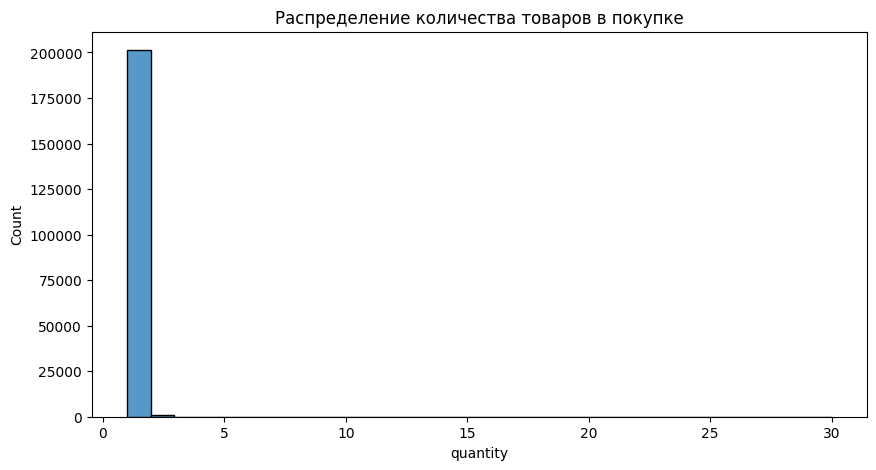

–ú–µ–¥–∏–∞–Ω–∞: 1.0, 95-–π –ø–µ—Ä—Ü–µ–Ω—Ç–∏–ª—å: 1.0


In [17]:
plt.figure(figsize=(10, 5))
sns.histplot(df_p['quantity'], bins=30, kde=False)
plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ —Ç–æ–≤–∞—Ä–æ–≤ –≤ –ø–æ–∫—É–ø–∫–µ')
plt.show()
print(f"–ú–µ–¥–∏–∞–Ω–∞: {df_p['quantity'].median()}, 95-–π –ø–µ—Ä—Ü–µ–Ω—Ç–∏–ª—å: {df_p['quantity'].quantile(0.95)}")

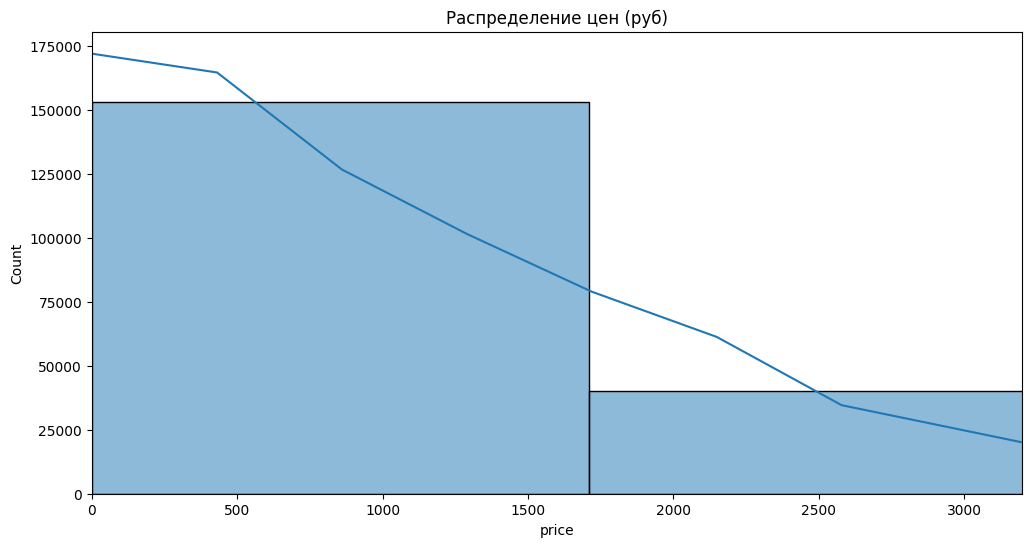

–û—Å–Ω–æ–≤–Ω—ã–µ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏:
count    202208.000000
mean       1193.301516
std        1342.252664
min           1.000000
25%         352.000000
50%         987.000000
75%        1699.000000
95%        3199.000000
max       85499.000000
Name: price, dtype: float64


In [18]:
plt.figure(figsize=(12, 6))
sns.histplot(df_p['price'], bins=50, kde=True)
plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ü–µ–Ω (—Ä—É–±)')
plt.xlim(0, df_p['price'].quantile(0.95)) # –ò—Å–∫–ª—é—á–∞–µ–º –≤—ã–±—Ä–æ—Å—ã
plt.show()

print(f"–û—Å–Ω–æ–≤–Ω—ã–µ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏:\n{df_p['price'].describe(percentiles=[0.25, 0.5, 0.75, 0.95])}")

–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –ø–æ –º–µ—Å—è—Ü–∞–º:
         unique_clients  total_purchases    avg_price
month                                                
2022-05            2369             4453  1649.410510
2022-06            5893            14215  1390.455997
2022-07            4637             9384  1369.667413
2022-08            3767             7381  1496.620377
2022-09            1967             5333  1392.033190
2022-10             349              741  1525.213225
2022-11            4549            20732  1185.409030
2022-12            4388            19382  1140.428594
2023-01             926             2680  1310.539552
2023-02             626             1900  1184.181579
2023-03            2846            12173  1353.656781
2023-04            4129            17501  1159.040969
2023-05            2631             9966  1037.930062
2023-06            5540            24888   896.232923
2023-07            2548            10218   925.378058
2023-08            1535             6367

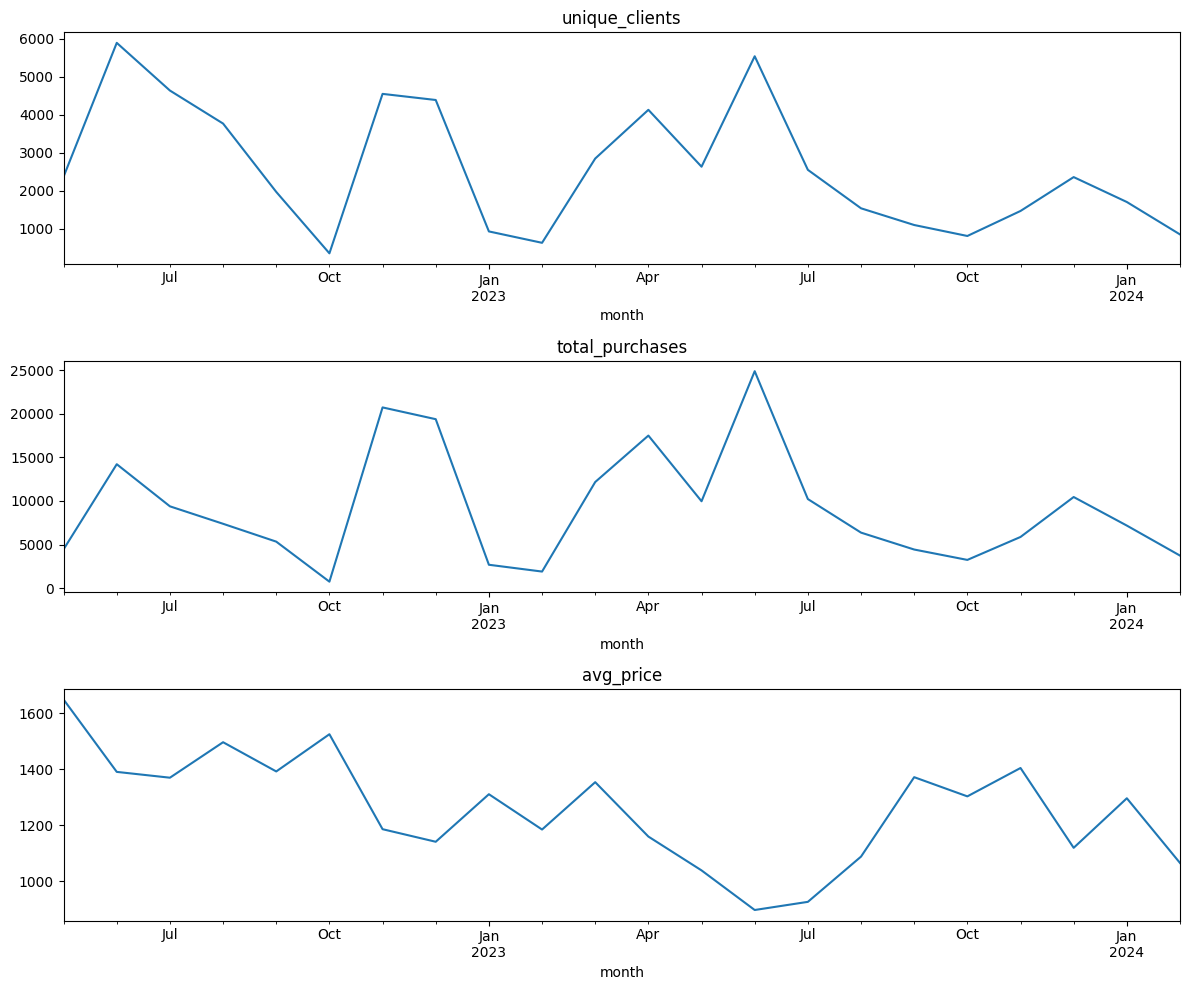

In [19]:
df_p['month'] = pd.to_datetime(df_p['date']).dt.to_period('M')
monthly_stats = df_p.groupby('month').agg(
    unique_clients=('client_id', 'nunique'),
    total_purchases=('client_id', 'count'),
    avg_price=('price', 'mean')
)

print("–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –ø–æ –º–µ—Å—è—Ü–∞–º:")
print(monthly_stats)

fig, axes = plt.subplots(3, 1, figsize=(12, 10))
for i, col in enumerate(['unique_clients', 'total_purchases', 'avg_price']):
    monthly_stats[col].plot(ax=axes[i], title=col)
plt.tight_layout()
plt.show()


–î–æ–ª—è –º–∞—Ä–∫–µ—Ç–∏–Ω–≥–æ–≤—ã—Ö –∫–∞–Ω–∞–ª–æ–≤:
channel
mobile_push    0.589661
email          0.410339
Name: proportion, dtype: float64


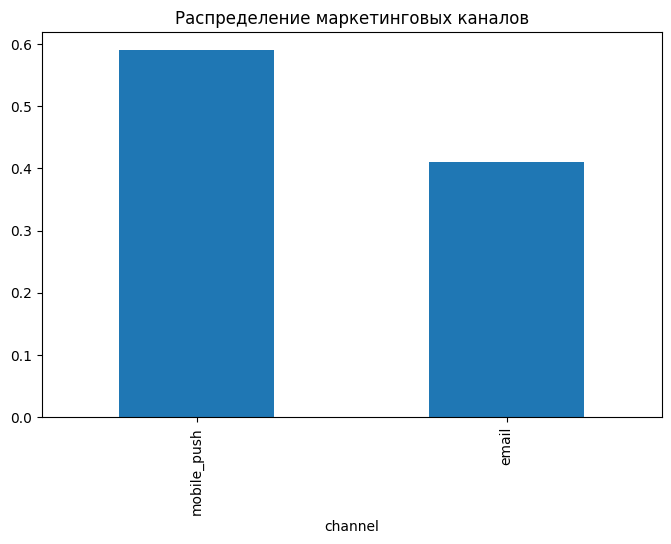

In [20]:
channel_dist = df_m['channel'].value_counts(normalize=True)

print("–î–æ–ª—è –º–∞—Ä–∫–µ—Ç–∏–Ω–≥–æ–≤—ã—Ö –∫–∞–Ω–∞–ª–æ–≤:")
print(channel_dist)

plt.figure(figsize=(8, 5))
channel_dist.plot(kind='bar')
plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –º–∞—Ä–∫–µ—Ç–∏–Ω–≥–æ–≤—ã—Ö –∫–∞–Ω–∞–ª–æ–≤')
plt.show()


–î–æ–ª—è —Å–æ–±—ã—Ç–∏–π:
event
send           7.110157e-01
open           2.422189e-01
click          3.895972e-02
purchase       5.076925e-03
hard_bounce    1.562270e-03
soft_bounce    8.307039e-04
unsubscribe    2.230020e-04
hbq_spam       6.460071e-05
complain       4.144493e-05
subscribe      6.672005e-06
close          7.849418e-08
Name: proportion, dtype: float64


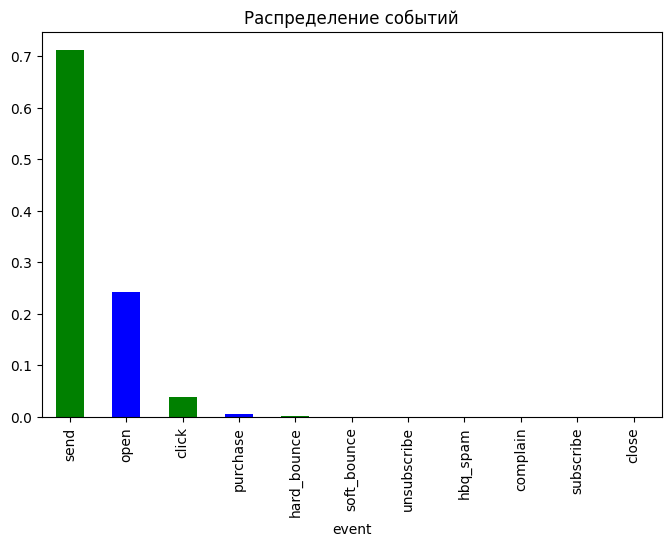

In [21]:
event_dist = df_m['event'].value_counts(normalize=True)

print("–î–æ–ª—è —Å–æ–±—ã—Ç–∏–π:")
print(event_dist)

plt.figure(figsize=(8, 5))
event_dist.plot(kind='bar', color=['green', 'blue'])
plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Å–æ–±—ã—Ç–∏–π')
plt.show()


–¢–æ–ø-10 –∫–∞–º–ø–∞–Ω–∏–π –ø–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤—É —Å–æ–æ–±—â–µ–Ω–∏–π (–∫–∞–º–ø–∞–Ω–∏—è : –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ):
14272 : 104479
14276 : 63826
4679 : 50621
11760 : 45985
14081 : 44884
14515 : 44711
14623 : 44339
12218 : 41172
14352 : 40210
14356 : 38937


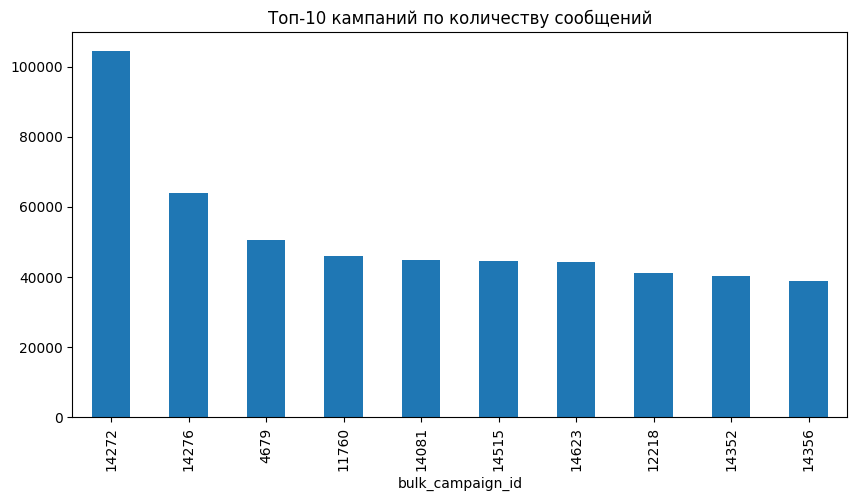

In [22]:
top_campaigns = df_m['bulk_campaign_id'].value_counts().head(10)

print("–¢–æ–ø-10 –∫–∞–º–ø–∞–Ω–∏–π –ø–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤—É —Å–æ–æ–±—â–µ–Ω–∏–π (–∫–∞–º–ø–∞–Ω–∏—è : –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ):")
for campaign, count in top_campaigns.items():
    print(f"{campaign} : {count}")

plt.figure(figsize=(10, 5))
top_campaigns.plot(kind='bar')
plt.title('–¢–æ–ø-10 –∫–∞–º–ø–∞–Ω–∏–π –ø–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤—É —Å–æ–æ–±—â–µ–Ω–∏–π')
plt.show()


–¢–æ–ø-10 –≥–ª–∞–≤–Ω—ã—Ö –∫–∞—Ç–µ–≥–æ—Ä–∏–π —Ç–æ–≤–∞—Ä–æ–≤ (–∫–∞—Ç–µ–≥–æ—Ä–∏—è : –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ):
4 : 112578
5562 : 46511
2 : 27429
6060 : 7559
-1 : 5579
5963 : 1272
3 : 11
1 : 3
5 : 2


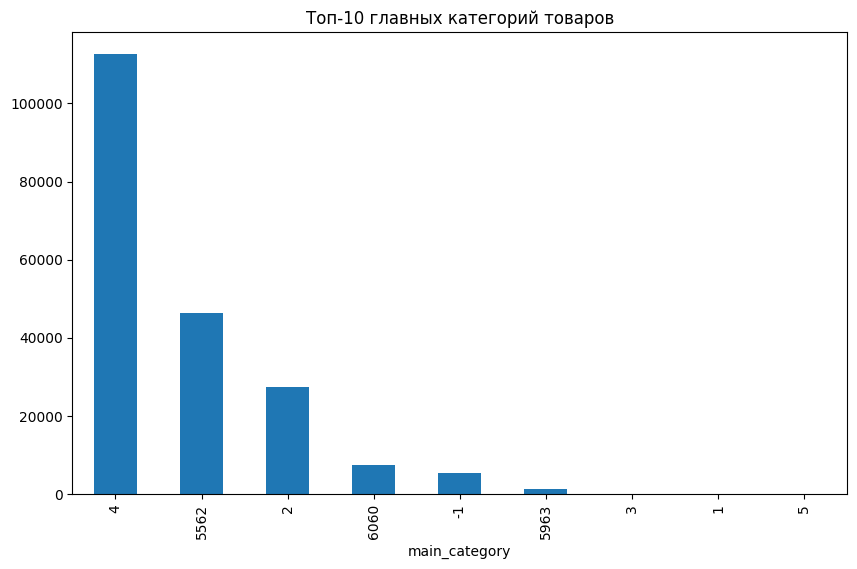

In [23]:
def extract_first_category(x):
    if not x:  # –µ—Å–ª–∏ –∑–Ω–∞—á–µ–Ω–∏–µ –ø—É—Å—Ç–æ–µ –∏–ª–∏ None
        return -1
    try:
        categories = literal_eval(x)
        if categories and len(categories) > 0:
            return categories[0]
        else:
            return -1
    except (ValueError, SyntaxError):
        return -1

df_p['main_category'] = df_p['category_ids'].apply(extract_first_category)

top_counts = df_p['main_category'].value_counts().head(10)

print("–¢–æ–ø-10 –≥–ª–∞–≤–Ω—ã—Ö –∫–∞—Ç–µ–≥–æ—Ä–∏–π —Ç–æ–≤–∞—Ä–æ–≤ (–∫–∞—Ç–µ–≥–æ—Ä–∏—è : –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ):")
for category, count in top_counts.items():
    print(f"{category} : {count}")

plt.figure(figsize=(10, 6))
top_counts.plot(kind='bar')
plt.title('–¢–æ–ø-10 –≥–ª–∞–≤–Ω—ã—Ö –∫–∞—Ç–µ–≥–æ—Ä–∏–π —Ç–æ–≤–∞—Ä–æ–≤')
plt.show()


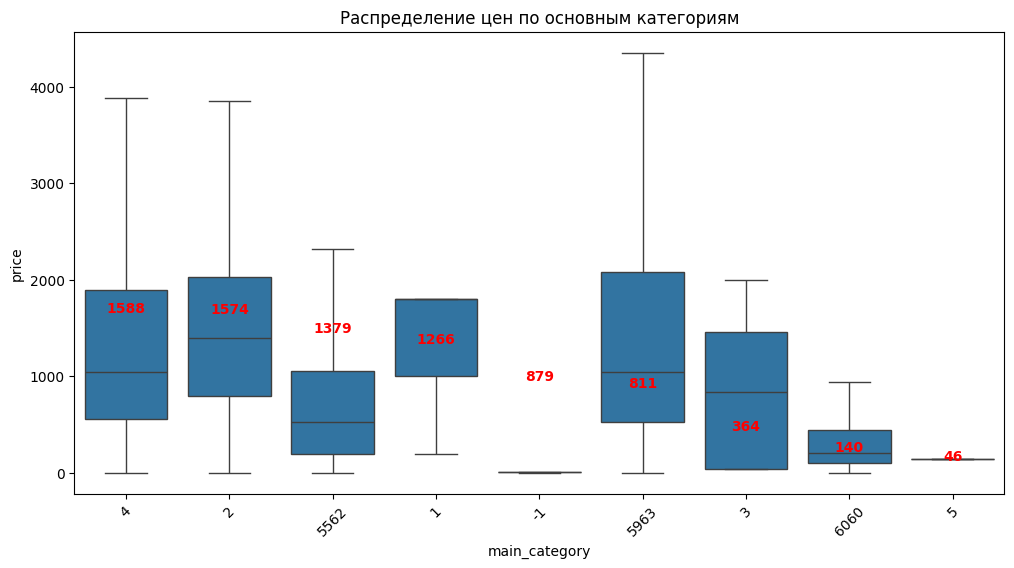

–°—Ä–µ–¥–Ω—è—è —Ü–µ–Ω–∞ –ø–æ –æ—Å–Ω–æ–≤–Ω—ã–º –∫–∞—Ç–µ–≥–æ—Ä–∏—è–º:
main_category
5963    1587.882075
2       1574.161107
4       1379.373901
1       1265.666667
3        879.363636
5562     810.807142
6060     364.272258
5        140.000000
-1        46.114357
Name: price, dtype: float64


In [24]:
top_categories = df_p['main_category'].value_counts().head(10)

# –§–∏–ª—å—Ç—Ä—É–µ–º –¥–∞–Ω–Ω—ã–µ –ø–æ —Ç–æ–ø-10 –∫–∞—Ç–µ–≥–æ—Ä–∏—è–º
df_top = df_p[df_p['main_category'].isin(top_categories.index)]

# –°—Ç—Ä–æ–∏–º –≥—Ä–∞—Ñ–∏–∫
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_top,
    x='main_category',
    y='price',
    showfliers=False
)
plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ü–µ–Ω –ø–æ –æ—Å–Ω–æ–≤–Ω—ã–º –∫–∞—Ç–µ–≥–æ—Ä–∏—è–º')
plt.xticks(rotation=45)

means = df_top.groupby('main_category')['price'].mean().sort_values(ascending=False)
for i, cat in enumerate(means.index):
    plt.text(i, means[cat] + means.max() * 0.05, f'{means[cat]:.0f}', 
             horizontalalignment='center', color='red', weight='bold')

plt.show()

print("–°—Ä–µ–¥–Ω—è—è —Ü–µ–Ω–∞ –ø–æ –æ—Å–Ω–æ–≤–Ω—ã–º –∫–∞—Ç–µ–≥–æ—Ä–∏—è–º:")
print(means)


–ú–µ–¥–∏–∞–Ω–Ω–æ–µ —á–∏—Å–ª–æ –ø–æ–∫—É–ø–æ–∫ –Ω–∞ –∫–ª–∏–µ–Ω—Ç–∞: 2.0
–ú–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–µ —á–∏—Å–ª–æ –ø–æ–∫—É–ø–æ–∫: 346


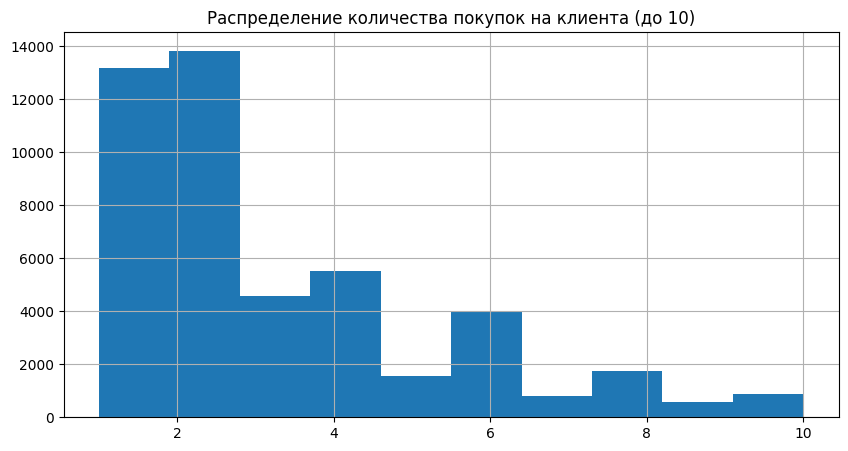

In [25]:
purchase_freq = df_p.groupby('client_id').size()
print(f"–ú–µ–¥–∏–∞–Ω–Ω–æ–µ —á–∏—Å–ª–æ –ø–æ–∫—É–ø–æ–∫ –Ω–∞ –∫–ª–∏–µ–Ω—Ç–∞: {purchase_freq.median()}")
print(f"–ú–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–µ —á–∏—Å–ª–æ –ø–æ–∫—É–ø–æ–∫: {purchase_freq.max()}")

plt.figure(figsize=(10, 5))
purchase_freq[purchase_freq <= 10].hist(bins=10)
plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ –ø–æ–∫—É–ø–æ–∫ –Ω–∞ –∫–ª–∏–µ–Ω—Ç–∞ (–¥–æ 10)')
plt.show()

–°—Ä–µ–¥–Ω–µ–µ –≤—Ä–µ–º—è –º–µ–∂–¥—É –ø–æ–∫—É–ø–∫–∞–º–∏: 7.1 –¥–Ω–µ–π


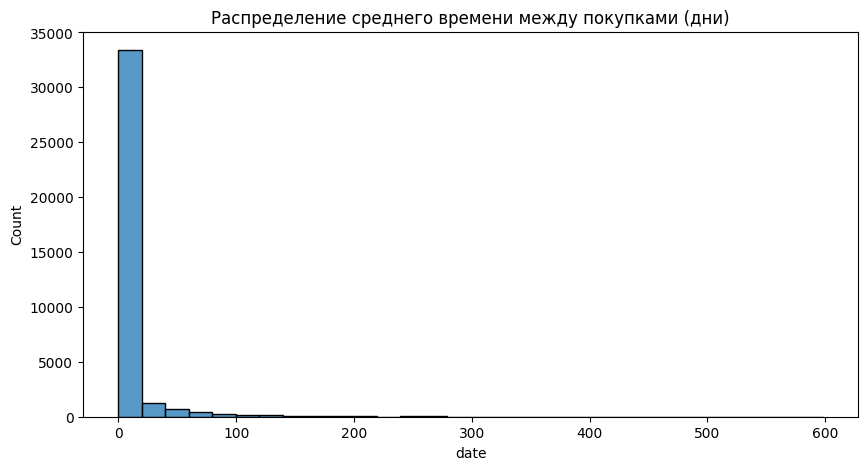

In [26]:
df_p['date'] = pd.to_datetime(df_p['date'])  

time_between = df_p.groupby('client_id')['date'].apply(lambda x: x.sort_values().diff().dt.days.mean())
print(f"–°—Ä–µ–¥–Ω–µ–µ –≤—Ä–µ–º—è –º–µ–∂–¥—É –ø–æ–∫—É–ø–∫–∞–º–∏: {time_between.mean():.1f} –¥–Ω–µ–π")

plt.figure(figsize=(10, 5))
sns.histplot(time_between.dropna(), bins=30)
plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Å—Ä–µ–¥–Ω–µ–≥–æ –≤—Ä–µ–º–µ–Ω–∏ –º–µ–∂–¥—É –ø–æ–∫—É–ø–∫–∞–º–∏ (–¥–Ω–∏)')
plt.show()


–ù–∞ –æ—Å–Ω–æ–≤–µ –ø—Ä–æ–≤–µ–¥—ë–Ω–Ω–æ–≥–æ EDA –º–æ–∂–Ω–æ —Å–¥–µ–ª–∞—Ç—å —Å–ª–µ–¥—É—é—â–∏–µ –≤—ã–≤–æ–¥—ã –ø–æ –¥–∞–Ω–Ω—ã–º –æ –ø–æ–∫—É–ø–∫–∞—Ö (`apparel-purchases`) –∏ –º–∞—Ä–∫–µ—Ç–∏–Ω–≥–æ–≤—ã–º —Å–æ–æ–±—â–µ–Ω–∏—è–º (`apparel-messages`):

---

### üì¶ **–ê–Ω–∞–ª–∏–∑ –ø–æ–∫—É–ø–æ–∫ (`apparel-purchases`)**

* **–†–∞–∑–º–µ—Ä –≤—ã–±–æ—Ä–∫–∏:** 202‚ÄØ208 –∑–∞–ø–∏—Å–µ–π –æ –ø–æ–∫—É–ø–∫–∞—Ö.
* **–ü–µ—Ä–∏–æ–¥:** —Å **2022-05-16** –ø–æ **2024-02-16**, —Ç.–µ. –ø–æ—á—Ç–∏ –¥–≤–∞ –≥–æ–¥–∞.
* **–£–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –∫–ª–∏–µ–Ω—Ç–æ–≤:** 49‚ÄØ849.

#### üìä –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ —Ç–æ–≤–∞—Ä–æ–≤ –≤ –æ–¥–Ω–æ–π –ø–æ–∫—É–ø–∫–µ

* **–ú–µ–¥–∏–∞–Ω–∞:** 1 —Ç–æ–≤–∞—Ä.
* **95-–π –ø–µ—Ä—Ü–µ–Ω—Ç–∏–ª—å:** —Ç–∞–∫–∂–µ 1 —Ç–æ–≤–∞—Ä.
* ‚û§ **–í—ã–≤–æ–¥:** –ø–æ–¥–∞–≤–ª—è—é—â–µ–µ –±–æ–ª—å—à–∏–Ω—Å—Ç–≤–æ –ø–æ–∫—É–ø–æ–∫ —Å–æ—Å—Ç–æ–∏—Ç –∏–∑ –æ–¥–Ω–æ–≥–æ —Ç–æ–≤–∞—Ä–∞, –º—É–ª—å—Ç–∏–ø–æ–∫—É–ø–∫–∏ –≤—Å—Ç—Ä–µ—á–∞—é—Ç—Å—è –∫—Ä–∞–π–Ω–µ —Ä–µ–¥–∫–æ.

#### üí∞ –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ü–µ–Ω

* **–°—Ä–µ–¥–Ω—è—è —Ü–µ–Ω–∞:** ‚âà 1‚ÄØ193 ‚ÇΩ.
* **–ú–µ–¥–∏–∞–Ω–∞:** 987 ‚ÇΩ.
* **95-–π –ø–µ—Ä—Ü–µ–Ω—Ç–∏–ª—å:** 3‚ÄØ199 ‚ÇΩ.
* **–ú–∞–∫—Å–∏–º–∞–ª—å–Ω–∞—è —Ü–µ–Ω–∞:** 85‚ÄØ499 ‚ÇΩ ‚Äî –ø—Ä–∏—Å—É—Ç—Å—Ç–≤—É—é—Ç **–∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω—ã–µ –≤—ã–±—Ä–æ—Å—ã**.
* ‚û§ **–í—ã–≤–æ–¥:** –±–æ–ª—å—à–∏–Ω—Å—Ç–≤–æ —Ç–æ–≤–∞—Ä–æ–≤ —Å—Ç–æ–∏—Ç –¥–æ 3‚Äì3.5 —Ç—ã—Å. —Ä—É–±., –Ω–æ –µ—Å—Ç—å –Ω–µ–±–æ–ª—å—à–æ–µ —á–∏—Å–ª–æ –¥–æ—Ä–æ–≥–∏—Ö —Ç–æ–≤–∞—Ä–æ–≤.

#### üìÖ –î–∏–Ω–∞–º–∏–∫–∞ –ø–æ –º–µ—Å—è—Ü–∞–º

* **–ü–∏–∫–∏ –ø—Ä–æ–¥–∞–∂:** –Ω–∞–±–ª—é–¥–∞—é—Ç—Å—è –≤ **–Ω–æ—è–±—Ä–µ –∏ –¥–µ–∫–∞–±—Ä–µ 2022**, –∞ —Ç–∞–∫–∂–µ –≤ **–∏—é–Ω–µ 2023**.
* **–°–ø–∞–¥—ã:** –º–∏–Ω–∏–º–∞–ª—å–Ω–∞—è –∞–∫—Ç–∏–≤–Ω–æ—Å—Ç—å –≤ –æ–∫—Ç—è–±—Ä–µ 2022 –∏ —Ñ–µ–≤—Ä–∞–ª–µ 2023.
* **–°—Ä–µ–¥–Ω—è—è —Ü–µ–Ω–∞ –ø–æ –º–µ—Å—è—Ü–∞–º:** —Å –Ω–∞—á–∞–ª–∞ 2023 –≥–æ–¥–∞ –Ω–∞–±–ª—é–¥–∞–µ—Ç—Å—è **—Å–Ω–∏–∂–µ–Ω–∏–µ —Ü–µ–Ω**, –≤ –æ—Å–æ–±–µ–Ω–Ω–æ—Å—Ç–∏ –ª–µ—Ç–æ–º.
* ‚û§ **–í—ã–≤–æ–¥:** –≤–µ—Ä–æ—è—Ç–Ω–æ, –±—ã–ª–∏ –∫—Ä—É–ø–Ω—ã–µ –∫–∞–º–ø–∞–Ω–∏–∏ –≤ –Ω–æ—è–±—Ä–µ‚Äì–¥–µ–∫–∞–±—Ä–µ (–ß—ë—Ä–Ω–∞—è –ø—è—Ç–Ω–∏—Ü–∞, –ù–æ–≤—ã–π –≥–æ–¥), –∞ —Ç–∞–∫–∂–µ –ª–µ—Ç–æ–º (–≤–æ–∑–º–æ–∂–Ω–æ, —Ä–∞—Å–ø—Ä–æ–¥–∞–∂–∏).

---

### üí¨ **–ê–Ω–∞–ª–∏–∑ –º–∞—Ä–∫–µ—Ç–∏–Ω–≥–æ–≤—ã—Ö —Å–æ–æ–±—â–µ–Ω–∏–π (`apparel-messages`)**

* **–†–∞–∑–º–µ—Ä:** 12‚ÄØ739‚ÄØ798 —Å–æ–æ–±—â–µ–Ω–∏–π.
* **–£–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –∫–ª–∏–µ–Ω—Ç–æ–≤:** 53‚ÄØ329 ‚Äî **–±–æ–ª—å—à–µ, —á–µ–º –≤ –ø–æ–∫—É–ø–∫–∞—Ö**, —Ç.–µ. –Ω–µ –≤—Å–µ —Ä–µ–∞–≥–∏—Ä—É—é—Ç –Ω–∞ —Å–æ–æ–±—â–µ–Ω–∏—è.

#### üì° –ö–∞–Ω–∞–ª—ã –∫–æ–º–º—É–Ω–∏–∫–∞—Ü–∏–∏

* **Mobile push:** 59‚ÄØ%
* **Email:** 41‚ÄØ%
* ‚û§ **–í—ã–≤–æ–¥:** —É–ø–æ—Ä –¥–µ–ª–∞–µ—Ç—Å—è –Ω–∞ push-—É–≤–µ–¥–æ–º–ª–µ–Ω–∏—è ‚Äî –±–æ–ª–µ–µ –ø—Ä—è–º–æ–π –∫–∞–Ω–∞–ª –¥–æ—Å—Ç–∞–≤–∫–∏.

#### ‚öôÔ∏è –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Å–æ–±—ã—Ç–∏–π –ø–æ —Å–æ–æ–±—â–µ–Ω–∏—è–º

* **–°–∞–º–æ–µ —á–∞—Å—Ç–æ–µ:** `send` (71‚ÄØ%)
* **–í–æ–≤–ª–µ—á–µ–Ω–∏–µ:**

  * `open`: 24‚ÄØ%
  * `click`: 3.9‚ÄØ%
  * `purchase`: 0.5‚ÄØ%
* **–ù–µ–≥–∞—Ç–∏–≤–Ω—ã–µ —Ä–µ–∞–∫—Ü–∏–∏:** `unsubscribe`, `spam`, `complain` ‚Äî –º–µ–Ω–µ–µ 0.1‚ÄØ%.
* ‚û§ **–í—ã–≤–æ–¥:** –æ—Ç —Ä–∞—Å—Å—ã–ª–æ–∫ –¥–æ –ø–æ–∫—É–ø–æ–∫ –¥–æ—Ö–æ–¥–∏—Ç **–º–µ–Ω–µ–µ 1‚ÄØ%** –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π. –≠—Ç–æ —Ç–∏–ø–∏—á–Ω–æ, –Ω–æ –º–æ–∂–Ω–æ —É–ª—É—á—à–∞—Ç—å.

#### üß¢ –¢–æ–ø-10 –∫–∞–º–ø–∞–Ω–∏–π

* –ù–∞–∏–±–æ–ª–µ–µ –∞–∫—Ç–∏–≤–Ω–∞—è –∫–∞–º–ø–∞–Ω–∏—è (ID 14272) ‚Äî **–±–æ–ª–µ–µ 100‚ÄØ000 —Å–æ–æ–±—â–µ–Ω–∏–π**.
* ‚û§ **–í—ã–≤–æ–¥:** –æ—Ç–¥–µ–ª—å–Ω—ã–µ –∫–∞–º–ø–∞–Ω–∏–∏ –∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω–æ –≤—ã–¥–µ–ª—è—é—Ç—Å—è –ø–æ –æ–±—ä—ë–º—É ‚Äî –≤–µ—Ä–æ—è—Ç–Ω–æ, –∫–ª—é—á–µ–≤—ã–µ –∞–∫—Ü–∏–∏.

---

### üõçÔ∏è **–ö–∞—Ç–µ–≥–æ—Ä–∏–∏ —Ç–æ–≤–∞—Ä–æ–≤**

* **–¢–æ–ø –∫–∞—Ç–µ–≥–æ—Ä–∏–π:**

  * `4` ‚Äî 112‚ÄØ578 –ø–æ–∫—É–ø–æ–∫
  * `5562`, `2`, `6060` ‚Äî –¥–∞–ª–µ–µ –ø–æ —É–±—ã–≤–∞–Ω–∏—é
  * –ü—Ä–∏—Å—É—Ç—Å—Ç–≤—É–µ—Ç `-1` ‚Äî –Ω–µ—Ä–∞—Å–ø–æ–∑–Ω–∞–Ω–Ω—ã–µ –∏–ª–∏ –æ—Ç—Å—É—Ç—Å—Ç–≤—É—é—â–∏–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–∏ (5‚ÄØ579 —Å–ª—É—á–∞–µ–≤).
* ‚û§ **–í—ã–≤–æ–¥:** –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ –ø–æ–Ω–∏–º–∞—Ç—å, —á—Ç–æ –∑–∞ –∫–∞—Ç–µ–≥–æ—Ä–∏—è `4` ‚Äî –≤–µ—Ä–æ—è—Ç–Ω–æ, –∫–ª—é—á–µ–≤–æ–π —Ç–æ–≤–∞—Ä –±—Ä–µ–Ω–¥–∞.

#### üí∏ –¶–µ–Ω—ã –ø–æ –∫–∞—Ç–µ–≥–æ—Ä–∏—è–º

* **–°–∞–º–∞—è –¥–æ—Ä–æ–≥–∞—è –∫–∞—Ç–µ–≥–æ—Ä–∏—è:** `5963` ‚Äî —Å—Ä–µ–¥–Ω—è—è —Ü–µ–Ω–∞ 1‚ÄØ588 ‚ÇΩ.
* **–ö–∞—Ç–µ–≥–æ—Ä–∏—è `4` (–æ—Å–Ω–æ–≤–Ω–∞—è –ø–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤—É):** —Å—Ä–µ–¥–Ω—è—è —Ü–µ–Ω–∞ ‚âà 1‚ÄØ379 ‚ÇΩ.
* **–ö–∞—Ç–µ–≥–æ—Ä–∏—è `-1` (–Ω–µ–æ–ø—Ä–µ–¥–µ–ª—ë–Ω–Ω—ã–µ):** –æ—á–µ–Ω—å –Ω–∏–∑–∫–∞—è —Å—Ä–µ–¥–Ω—è—è —Ü–µ–Ω–∞ ‚Äî 46 ‚ÇΩ.
* ‚û§ **–í—ã–≤–æ–¥:** –æ–ø—Ä–µ–¥–µ–ª—ë–Ω–Ω—ã–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–∏ —Ç—è–Ω—É—Ç —Å—Ä–µ–¥–Ω–∏–π —á–µ–∫ –≤–≤–µ—Ä—Ö ‚Äî –º–æ–∂–Ω–æ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å —ç—Ç–æ –¥–ª—è —Å–µ–≥–º–µ–Ω—Ç–∞—Ü–∏–∏ –∏ —Ç–∞—Ä–≥–µ—Ç–∏—Ä–æ–≤–∞–Ω–∏—è.

---

### üë§ **–ü–æ–≤–µ–¥–µ–Ω–∏–µ –∫–ª–∏–µ–Ω—Ç–æ–≤**

* **–ú–µ–¥–∏–∞–Ω–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–æ–∫—É–ø–æ–∫ –Ω–∞ –∫–ª–∏–µ–Ω—Ç–∞:** **1**.
* **–ú–∞–∫—Å–∏–º—É–º:** –æ–¥–∏–Ω –∫–ª–∏–µ–Ω—Ç —Å–¥–µ–ª–∞–ª **210 –ø–æ–∫—É–ø–æ–∫**.
* ‚û§ **–í—ã–≤–æ–¥:** –±–æ–ª—å—à–∏–Ω—Å—Ç–≤–æ –∫–ª–∏–µ–Ω—Ç–æ–≤ ‚Äî –æ–¥–Ω–æ–∫—Ä–∞—Ç–Ω—ã–µ –ø–æ–∫—É–ø–∞—Ç–µ–ª–∏. –ï—Å—Ç—å **—Ü–µ–Ω–Ω—ã–µ –ø–æ—Å—Ç–æ—è–Ω–Ω—ã–µ –∫–ª–∏–µ–Ω—Ç—ã**, –∫–æ—Ç–æ—Ä—ã—Ö –º–æ–∂–Ω–æ –≤—ã–¥–µ–ª—è—Ç—å –∏ –ø–æ–æ—â—Ä—è—Ç—å.

---

### üìå –û–±—â–∏–µ –∏–Ω—Å–∞–π—Ç—ã:

1. **–û–≥—Ä–æ–º–Ω—ã–π –æ–±—ä—ë–º –º–∞—Ä–∫–µ—Ç–∏–Ω–≥–æ–≤—ã—Ö —Å–æ–æ–±—â–µ–Ω–∏–π** —Å –Ω–∏–∑–∫–∏–º –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç–æ–º –∫–æ–Ω–≤–µ—Ä—Å–∏–∏ (0.5% –≤ –ø–æ–∫—É–ø–∫–∏).
2. **–ë–æ–ª—å—à–∏–Ω—Å—Ç–≤–æ –∫–ª–∏–µ–Ω—Ç–æ–≤ –¥–µ–ª–∞—é—Ç —Ç–æ–ª—å–∫–æ –æ–¥–Ω—É –ø–æ–∫—É–ø–∫—É** ‚Äî –≤–æ–∑–º–æ–∂–µ–Ω –ø–æ—Ç–µ–Ω—Ü–∏–∞–ª –¥–ª—è –ø–æ–≤—ã—à–µ–Ω–∏—è LTV —á–µ—Ä–µ–∑ –ø–æ–≤—Ç–æ—Ä–Ω—ã–µ –∫–∞—Å–∞–Ω–∏—è.
3. **–¢–æ–≤–∞—Ä—ã —Å–∏–ª—å–Ω–æ —Ä–∞–∑–ª–∏—á–∞—é—Ç—Å—è –ø–æ —Ü–µ–Ω–µ –∏ –∫–∞—Ç–µ–≥–æ—Ä–∏–∏** ‚Äî —Ü–µ–ª–µ—Å–æ–æ–±—Ä–∞–∑–Ω–æ —Å–µ–≥–º–µ–Ω—Ç–∏—Ä–æ–≤–∞—Ç—å –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è.
4. **–ü–µ—Ä–∏–æ–¥—ã –≤—ã—Å–æ–∫–æ–π –∞–∫—Ç–∏–≤–Ω–æ—Å—Ç–∏** ‚Äî –∫–æ–Ω–µ—Ü 2022 –∏ –ª–µ—Ç–æ 2023 –≥–æ–¥–∞. –í–æ–∑–º–æ–∂–Ω–æ, —Å—Ç–æ–∏—Ç –æ—Ä–∏–µ–Ω—Ç–∏—Ä–æ–≤–∞—Ç—å—Å—è –Ω–∞ —ç—Ç–∏ —Å–µ–∑–æ–Ω—ã –≤ –¥–∞–ª—å–Ω–µ–π—à–µ–º.
5. **Push-—É–≤–µ–¥–æ–º–ª–µ–Ω–∏—è ‚Äî –æ—Å–Ω–æ–≤–Ω–æ–π –∫–∞–Ω–∞–ª –∫–æ–º–º—É–Ω–∏–∫–∞—Ü–∏–∏**, –æ–¥–Ω–∞–∫–æ –≤–∞–∂–Ω–æ –Ω–µ –∏–≥–Ω–æ—Ä–∏—Ä–æ–≤–∞—Ç—å –∏ email (–ø–æ—á—Ç–∏ 41%).


# –û–ë–£–ß–ï–ù–ò–ï –ò –í–´–ë–û–† –ú–û–î–ï–õ–ò

In [29]:
def find_business_threshold(y_true, probs, min_recall=0.7):
    """–ù–∞—Ö–æ–¥–∏—Ç –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã–π –ø–æ—Ä–æ–≥ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ —Å —É—á–µ—Ç–æ–º –º–∏–Ω–∏–º–∞–ª—å–Ω–æ–≥–æ recall"""
    precisions, recalls, thresholds = precision_recall_curve(y_true, probs)
    
    # –†–∞—Å—Å—á–∏—Ç—ã–≤–∞–µ–º F2-–º–µ—Ä—É (–±–æ–ª—å—à–∏–π –≤–µ—Å recall)
    numerator = 5 * precisions[:-1] * recalls[:-1]
    denominator = 4 * precisions[:-1] + recalls[:-1] + 1e-10
    f2_scores = numerator / denominator
    
    # –ò—â–µ–º –ø–æ—Ä–æ–≥, –≥–¥–µ recall >= min_recall —Å –º–∞–∫—Å–∏–º–∞–ª—å–Ω—ã–º F2
    mask = recalls[:-1] >= min_recall
    if not np.any(mask):
        return 0.5  # –í–æ–∑–≤—Ä–∞—â–∞–µ–º –ø–æ—Ä–æ–≥ –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é, –µ—Å–ª–∏ –Ω–µ –Ω–∞–π–¥–µ–Ω–æ
    
    best_idx = np.argmax(f2_scores[mask])
    return thresholds[mask][best_idx]

In [30]:
# –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö
X = df_processed.drop(columns=['target', 'client_id', 'date_purchase', 
                              'date_message', 'created_at', 'message_id'])
y = df_processed['target']

def generate_features(df):
    # –°–æ–∑–¥–∞–µ–º –∫–æ–ø–∏—é, —á—Ç–æ–±—ã –∏–∑–±–µ–∂–∞—Ç—å SettingWithCopyWarning
    df = df.copy()
    
    if 'price' in df.columns and 'bulk_campaign_id' in df.columns:
        df['price_per_campaign'] = df['price'] / (df['bulk_campaign_id'].astype('category').cat.codes.add(100))
    
    # –í—Ä–µ–º–µ–Ω–Ω—ã–µ —Ñ–∏—á–∏
    if 'days_since_message' in df.columns:
        df['is_recent_message'] = (df['days_since_message'] <= 7).astype(int)
    
    # –ê–≥—Ä–µ–≥–∞—Ç—ã –ø–æ –∫–∞–º–ø–∞–Ω–∏—è–º
    if 'bulk_campaign_id' in df.columns and 'price' in df.columns and 'days_since_purchase' in df.columns:
        campaign_stats = df.groupby('bulk_campaign_id').agg({
            'price': ['mean', 'std'],
            'days_since_purchase': 'median'
        })
        campaign_stats.columns = ['campaign_price_mean', 'campaign_price_std', 'campaign_median_days']
        df = df.merge(campaign_stats, on='bulk_campaign_id', how='left')

        # –í–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏–µ –∫–ª—é—á–µ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
        df['price_elasticity'] = df['price'] * df['campaign_price_std']
        
        # –í—Ä–µ–º–µ–Ω–Ω—ã–µ –ø–∞—Ç—Ç–µ—Ä–Ω—ã
        df['purchase_intensity'] = 1 / (df['days_since_purchase'].add(0.1))
        
        # –ö–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏—è
        if 'main_category' in df.columns:
            premium_threshold = df['campaign_price_mean'].quantile(0.75)
            df['premium_campaign'] = ((df['campaign_price_mean'] > premium_threshold) & 
                                    (df['main_category'] == 'premium')).astype(int)
    
    return df

# –ü—Ä–∏–º–µ–Ω—è–µ–º –≥–µ–Ω–µ—Ä–∞—Ü–∏—é —Ñ–∏—á–µ–π
X = generate_features(X)

# –†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –Ω–∞ train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [31]:
# –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
cat_features = X_train.select_dtypes(include=['category', 'object']).columns.tolist()

# –Ø–≤–Ω–æ–µ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
for col in cat_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')


In [32]:
# –ê–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–∏–π –æ—Ç–±–æ—Ä —Ñ–∏—á–µ–π
print("\n=== Feature Selection ===")
base_model = CatBoostClassifier(
    iterations=1000,  
    learning_rate=0.05,
    depth=6,
    cat_features=cat_features,
    eval_metric='PRAUC',
    early_stopping_rounds=50,
    thread_count=-1,  
    random_seed=42,
    verbose=100
)

print("Running feature importance selection...")
base_model.fit(X_train, y_train)
importance = base_model.get_feature_importance()
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importance
}).sort_values('importance', ascending=False)

# –í—ã–±–∏—Ä–∞–µ–º —Ç–æ–ø-N —Ñ–∏—á–µ–π
top_n = min(30, len(X_train.columns))
final_features = importance_df.head(top_n)['feature'].tolist()

print(f"\nSelected top {top_n} features:")
print(importance_df.head(top_n))


=== Feature Selection ===
Running feature importance selection...
0:	learn: 0.0581728	total: 210ms	remaining: 3m 29s
100:	learn: 0.3323454	total: 15.1s	remaining: 2m 14s
200:	learn: 0.4020121	total: 30.4s	remaining: 2m
300:	learn: 0.4512834	total: 45.9s	remaining: 1m 46s
400:	learn: 0.4866175	total: 1m 1s	remaining: 1m 31s
500:	learn: 0.5148633	total: 1m 16s	remaining: 1m 16s
600:	learn: 0.5400459	total: 1m 32s	remaining: 1m 1s
700:	learn: 0.5626776	total: 1m 47s	remaining: 45.8s
800:	learn: 0.5849787	total: 2m 2s	remaining: 30.5s
900:	learn: 0.6054819	total: 2m 18s	remaining: 15.2s
999:	learn: 0.6244588	total: 2m 33s	remaining: 0us

Selected top 21 features:
                     feature  importance
15       campaign_price_mean   16.499851
16        campaign_price_std   12.438422
5            categories_hash   10.424994
19        purchase_intensity    8.525672
8        days_since_purchase    8.418205
17      campaign_median_days    8.162015
2           bulk_campaign_id    7.076320
13 

In [33]:
# –£–¥–∞–ª—è–µ–º 'bulk_campaign_id' –∏–∑ —Å–ø–∏—Å–∫–∞ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
if 'bulk_campaign_id' in final_features:
    final_features.remove('bulk_campaign_id')

# –û–±–Ω–æ–≤–ª—è–µ–º –¥–∞–Ω–Ω—ã–µ —Å –æ—Ç–æ–±—Ä–∞–Ω–Ω—ã–º–∏ —Ñ–∏—á–∞–º–∏
X_train = X_train[final_features]
X_test = X_test[final_features]
cat_features = [f for f in cat_features if f in final_features]


In [34]:
num_features = X_train.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns.tolist()
cat_features = X_train.select_dtypes(include=['category']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

models = {
    'Logistic Regression': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
    ]),
    
    'KNN': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier(n_neighbors=50, weights='distance'))
    ]),
    
    'LightGBM': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LGBMClassifier(
            n_estimators=1000,
            learning_rate=0.05,
            num_leaves=31,
            class_weight='balanced',
            random_state=42,
            n_jobs=1))
    ]),
    
    'CatBoost': CatBoostClassifier(
        iterations=1000,
        learning_rate=0.02,
        depth=8,
        l2_leaf_reg=7,
        cat_features=cat_features,
        eval_metric='PRAUC',
        early_stopping_rounds=100,
        class_weights=[1, 25],
        one_hot_max_size=15,
        bootstrap_type='Bayesian',
        random_seed=42,
        thread_count=-1,
        verbose=500
    )
}

In [35]:
# –û–±—É—á–µ–Ω–∏–µ –∏ –æ—Ü–µ–Ω–∫–∞ –≤—Å–µ—Ö –º–æ–¥–µ–ª–µ–π —Å –∫—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏–µ–π
results = {}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\n=== Training {name} ===")
    
    # –ú–µ—Ç—Ä–∏–∫–∏ –¥–ª—è –∫—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏–∏
    scoring = {
        'PR-AUC': 'average_precision',
        'ROC-AUC': 'roc_auc',
        'F2': make_scorer(f1_score, pos_label=1, zero_division=0)
    }
    
    if name == 'CatBoost':
        cb_params = {
            'iterations': 1000,
            'learning_rate': 0.02,
            'depth': 8,
            'l2_leaf_reg': 7,
            'loss_function': 'Logloss',
            'cat_features': cat_features,
            'eval_metric': 'PRAUC',
            'custom_metric': ['PRAUC', 'AUC'],
            'early_stopping_rounds': 100,
            'class_weights': [1, 25],
            'one_hot_max_size': 15,
            'bootstrap_type': 'Bayesian',
            'random_seed': 42,
            'thread_count': 1,
            'verbose': 500
        }

        cv_data = catboost_cv(
            params=cb_params,
            pool=Pool(X_train, y_train, cat_features=cat_features),
            fold_count=3,
            partition_random_seed=42,
            shuffle=True,
            stratified=True
        )

        pr_auc_mean = np.mean(cv_data['test-PRAUC-mean'])
        roc_auc_mean = np.mean(cv_data['test-AUC-mean'])

        model.fit(X_train, y_train, eval_set=(X_test, y_test))
        f2_mean = None  # –ú–æ–∂–Ω–æ –æ—Ç–¥–µ–ª—å–Ω–æ –ø–æ—Å—á–∏—Ç–∞—Ç—å F2 –Ω–∞ —Ç–µ—Å—Ç–µ

    else:
        # –î–ª—è –æ—Å—Ç–∞–ª—å–Ω—ã—Ö –º–æ–¥–µ–ª–µ–π –∏—Å–ø–æ–ª—å–∑—É–µ–º cross_validate
        cv_results = cross_validate(
            model,
            X_train,
            y_train,
            cv=cv,
            scoring=scoring,
            n_jobs=1,
            return_train_score=False
        )
        
        pr_auc_mean = np.mean(cv_results['test_PR-AUC'])
        roc_auc_mean = np.mean(cv_results['test_ROC-AUC'])
        f2_mean = np.mean(cv_results['test_F2'])
        
        # –û–±—É—á–∞–µ–º —Ñ–∏–Ω–∞–ª—å–Ω—É—é –º–æ–¥–µ–ª—å –Ω–∞ –≤—Å–µ—Ö —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö
        model.fit(X_train, y_train)
    
    # –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –Ω–∞ —Ç–µ—Å—Ç–æ–≤–æ–º –Ω–∞–±–æ—Ä–µ
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
    
    # –†–∞—Å—á–µ—Ç –º–µ—Ç—Ä–∏–∫ –Ω–∞ —Ç–µ—Å—Ç–æ–≤–æ–º –Ω–∞–±–æ—Ä–µ
    pr_auc_test = average_precision_score(y_test, y_proba)
    roc_auc_test = roc_auc_score(y_test, y_proba)
    
    # –ü–æ–¥–±–æ—Ä –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–≥–æ –ø–æ—Ä–æ–≥–∞
    business_threshold = find_business_threshold(y_test, y_proba, min_recall=0.7)
    y_pred = (y_proba >= business_threshold).astype(int)
    
    # –†–∞—Å—á–µ—Ç F2-score –Ω–∞ —Ç–µ—Å—Ç–µ
    f2_test = f1_score(y_test, y_pred, average='binary', pos_label=1, zero_division=0)
    
    # –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
    results[name] = {
        'CV PR-AUC': pr_auc_mean,
        'CV ROC-AUC': roc_auc_mean,
        'CV F2-score': f2_mean if name != 'CatBoost' else None,
        'Test PR-AUC': pr_auc_test,
        'Test ROC-AUC': roc_auc_test,
        'Test F2-score': f2_test,
        'Threshold': business_threshold,
        'Model': model
    }
    
    print(f"{name} CV PR-AUC: {pr_auc_mean:.4f}, Test PR-AUC: {pr_auc_test:.4f}")
    print(f"{name} CV ROC-AUC: {roc_auc_mean:.4f}, Test ROC-AUC: {roc_auc_test:.4f}")
    if name != 'CatBoost':
        print(f"{name} CV F2-score: {f2_mean:.4f}, Test F2-score: {f2_test:.4f}")



=== Training Logistic Regression ===
Logistic Regression CV PR-AUC: 0.0682, Test PR-AUC: 0.0689
Logistic Regression CV ROC-AUC: 0.6384, Test ROC-AUC: 0.6398
Logistic Regression CV F2-score: 0.1075, Test F2-score: 0.1002

=== Training KNN ===
KNN CV PR-AUC: 0.7719, Test PR-AUC: 0.8566
KNN CV ROC-AUC: 0.9338, Test ROC-AUC: 0.9588
KNN CV F2-score: 0.7627, Test F2-score: 0.7906

=== Training LightGBM ===
[LightGBM] [Info] Number of positive: 16918, number of negative: 412852
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2797
[LightGBM] [Info] Number of data points in the train set: 429770, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive:

In [36]:
print(cv_data.columns)


Index(['iterations', 'test-PRAUC-mean', 'test-PRAUC-std', 'train-PRAUC-mean',
       'train-PRAUC-std', 'test-Logloss-mean', 'test-Logloss-std',
       'train-Logloss-mean', 'train-Logloss-std', 'test-AUC-mean',
       'test-AUC-std'],
      dtype='object')



=== Model Comparison ===
                    CV PR-AUC Test PR-AUC CV ROC-AUC Test ROC-AUC CV F2-score  \
KNN                  0.771886     0.85656    0.93379      0.95881    0.762717   
LightGBM             0.787057    0.793776   0.977107     0.980574    0.519795   
CatBoost             0.885364    0.614225   0.875392     0.940176        None   
Logistic Regression  0.068167    0.068881   0.638396     0.639781    0.107457   

                    Test F2-score Threshold  
KNN                      0.790556  0.210231  
LightGBM                 0.660541  0.620395  
CatBoost                 0.495321  0.626722  
Logistic Regression      0.100233  0.473031  

Best model: KNN (F2-score: 0.7906)


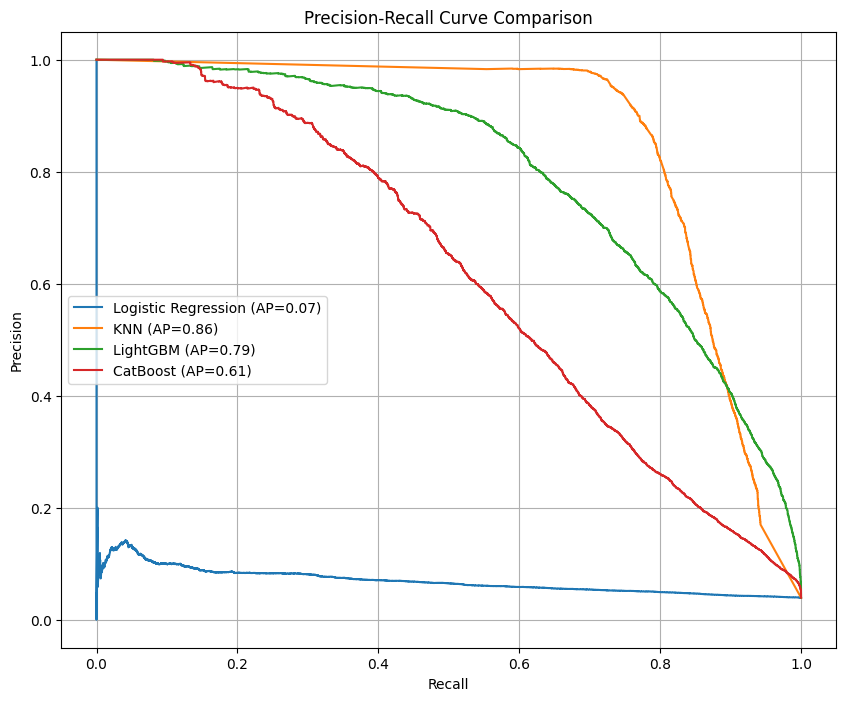

In [37]:
# –°—Ä–∞–≤–Ω–µ–Ω–∏–µ –º–æ–¥–µ–ª–µ–π
print("\n=== Model Comparison ===")
results_df = pd.DataFrame(results).T
print(results_df[['CV PR-AUC', 'Test PR-AUC', 
                 'CV ROC-AUC', 'Test ROC-AUC',
                 'CV F2-score', 'Test F2-score', 
                 'Threshold']].sort_values('Test F2-score', ascending=False))

# –í—ã–±–æ—Ä –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏
best_model_name = results_df['Test F2-score'].idxmax()
best_model = results[best_model_name]['Model']
print(f"\nBest model: {best_model_name} (F2-score: {results[best_model_name]['Test F2-score']:.4f})")

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –∫—Ä–∏–≤—ã—Ö Precision-Recall –¥–ª—è –≤—Å–µ—Ö –º–æ–¥–µ–ª–µ–π
plt.figure(figsize=(10, 8))
for name, res in results.items():
    if hasattr(res['Model'], 'predict_proba'):
        y_proba = res['Model'].predict_proba(X_test)[:, 1]
    else:
        y_proba = res['Model'].decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
    
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall, precision, label=f'{name} (AP={res["Test PR-AUC"]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.grid()
plt.show()

<Figure size 500x400 with 0 Axes>

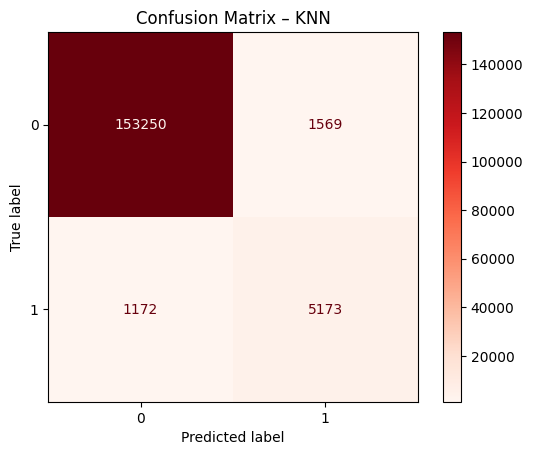

In [38]:
# –ö–æ–Ω—Ñ—å—é–∂–Ω-–º–∞—Ç—Ä–∏—Ü–∞ –¥–ª—è –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏
best_threshold = results[best_model_name]['Threshold']
best_clf       = results[best_model_name]['Model']

# –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏/–æ—Ü–µ–Ω–∫–∏ –¥–ª—è —Ç–µ—Å—Ç–∞
if hasattr(best_clf, 'predict_proba'):
    y_best_proba = best_clf.predict_proba(X_test)[:, 1]
else:
    y_best_proba = best_clf.decision_function(X_test)
    y_best_proba = (y_best_proba - y_best_proba.min()) / (y_best_proba.max() - y_best_proba.min())

# –±–∏–Ω–∞—Ä–Ω—ã–µ –ø—Ä–æ–≥–Ω–æ–∑—ã –ø–æ –Ω–∞–π–¥–µ–Ω–Ω–æ–º—É –ø–æ—Ä–æ–≥—É
y_best_pred = (y_best_proba >= best_threshold).astype(int)

# —Å–∞–º–∞ –º–∞—Ç—Ä–∏—Ü–∞
cm = confusion_matrix(y_test, y_best_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_clf.classes_)

plt.figure(figsize=(5, 4))
disp.plot(values_format='d', cmap='Reds')      # –±–µ–∑ —è–≤–Ω–æ–≥–æ —É–∫–∞–∑–∞–Ω–∏—è —Ü–≤–µ—Ç–æ–≤
plt.title(f'Confusion Matrix ‚Äì {best_model_name}')
plt.grid(False)
plt.show()


–ù–∞ –æ—Å–Ω–æ–≤–µ –∫–æ–Ω—Ñ—å—é–∂–Ω-–º–∞—Ç—Ä–∏—Ü—ã –¥–ª—è –º–æ–¥–µ–ª–∏ **KNN**:

```
                 Predicted
               |    0    |    1
         --------------------------
True    0   | 153250  |  1569     |  ‚Üí –ö–ª–∞—Å—Å "–Ω–µ –∫—É–ø–∏–ª"
        1   |   1172   |  5173     |  ‚Üí –ö–ª–∞—Å—Å "–∫—É–ø–∏–ª"
```

---

### üìä –í—ã–≤–æ–¥—ã:

1. **–ú–æ–¥–µ–ª—å KNN –ø–æ–∫–∞–∑–∞–ª–∞ —Ö–æ—Ä–æ—à—É—é —Å–ø–æ—Å–æ–±–Ω–æ—Å—Ç—å –ø—Ä–µ–¥—Å–∫–∞–∑—ã–≤–∞—Ç—å –ø–æ–∫—É–ø–∫—É:**

   * –ü—Ä–∞–≤–∏–ª—å–Ω–æ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–æ **5173** –ø–æ–∫—É–ø–∞—Ç–µ–ª–µ–π –∏–∑ **6345** (—á—Ç–æ —Å–æ—Å—Ç–∞–≤–ª—è–µ—Ç ‚âà‚ÄØ83.4% recall –ø–æ –∫–ª–∞—Å—Å—É 1).
   * F2-score –º–æ–¥–µ–ª–∏ (0.7906) ‚Äî –≤—ã—Å–æ–∫–∞—è –º–µ—Ç—Ä–∏–∫–∞, –æ—Å–æ–±–µ–Ω–Ω–æ —É—á–∏—Ç—ã–≤–∞—è –∞–∫—Ü–µ–Ω—Ç –Ω–∞ **–ø–æ–ª–Ω–æ—Ç—É** (recall), –≤–∞–∂–Ω—É—é –≤ –∑–∞–¥–∞—á–∞—Ö –ø—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏—è —Ä–µ–¥–∫–∏—Ö, –Ω–æ —Ü–µ–Ω–Ω—ã—Ö —Å–æ–±—ã—Ç–∏–π (–ø–æ–∫—É–ø–æ–∫).

2. **–ù–∏–∑–∫–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ª–æ–∂–Ω—ã—Ö –ø–æ–ª–æ–∂–∏—Ç–µ–ª—å–Ω—ã—Ö:**

   * –¢–æ–ª—å–∫–æ **1569** —Å–ª—É—á–∞—è, –∫–æ–≥–¥–∞ –º–æ–¥–µ–ª—å –æ—à–∏–±–æ—á–Ω–æ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–ª–∞ –ø–æ–∫—É–ø–∫—É (false positive), –ø—Ä–∏ –æ–±—â–µ–º –æ–±—ä—ë–º–µ –±–æ–ª–µ–µ 154 —Ç—ã—Å—è—á –æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω—ã—Ö –ø—Ä–∏–º–µ—Ä–æ–≤.
   * –≠—Ç–æ –≥–æ–≤–æ—Ä–∏—Ç –æ —Ç–æ–º, —á—Ç–æ –º–æ–¥–µ–ª—å **–¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ —Ö–æ—Ä–æ—à–æ —Å–±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∞–Ω–∞** –∏ –Ω–µ "–ø–µ—Ä–µ–ø—Ä–µ–¥—Å–∫–∞–∑—ã–≤–∞–µ—Ç" –ø–æ–∫—É–ø–∫—É.

3. **–û—á–µ–Ω—å –≤—ã—Å–æ–∫–∞—è —Ç–æ—á–Ω–æ—Å—Ç—å –ø–æ –∫–ª–∞—Å—Å—É 0 (–Ω–µ –∫—É–ø–∏–ª–∏):**

   * –ò–∑ 154819 —Ä–µ–∞–ª—å–Ω—ã—Ö –Ω–µ-–ø–æ–∫—É–ø–∞—Ç–µ–ª–µ–π, **153250** –±—ã–ª–∏ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω—ã –ø—Ä–∞–≤–∏–ª—å–Ω–æ.
   * –≠—Ç–æ –¥–∞—ë—Ç —Ç–æ—á–Ω–æ—Å—Ç—å –ø–æ –∫–ª–∞—Å—Å—É 0 ‚âà‚ÄØ98.6%, —á—Ç–æ –∫—Ä–∏—Ç–∏—á–Ω–æ –¥–ª—è –º–∏–Ω–∏–º–∏–∑–∞—Ü–∏–∏ –∑–∞—Ç—Ä–∞—Ç –Ω–∞ –æ–±—Ä–∞–±–æ—Ç–∫—É "–ø—É—Å—Ç—ã—Ö" –ª–∏–¥–æ–≤.

---

### üìà –ë–∏–∑–Ω–µ—Å:

* –ú–æ–¥–µ–ª—å **–Ω–∞–¥–µ–∂–Ω–æ –æ–ø—Ä–µ–¥–µ–ª—è–µ—Ç** —Ç–µ—Ö, –∫—Ç–æ **–Ω–µ –∫—É–ø–∏—Ç** (True Negative = 153250), —á—Ç–æ –ø–æ–º–æ–≥–∞–µ—Ç **—Å–æ–∫—Ä–∞—Ç–∏—Ç—å –∏–∑–¥–µ—Ä–∂–∫–∏ –Ω–∞ –º–∞—Ä–∫–µ—Ç–∏–Ω–≥**.
* –ë–æ–ª–µ–µ –≤–∞–∂–Ω–æ: –º–æ–¥–µ–ª—å **—ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ –≤—ã—è–≤–ª—è–µ—Ç –ø–æ–∫—É–ø–∞—Ç–µ–ª–µ–π** (True Positive = 5173), –ø–æ–∑–≤–æ–ª—è—è –±–∏–∑–Ω–µ—Å—É **—Å—Ñ–æ–∫—É—Å–∏—Ä–æ–≤–∞—Ç—å —É—Å–∏–ª–∏—è –Ω–∞ –∫–æ–Ω–≤–µ—Ä—Å–∏–∏** —ç—Ç–∏—Ö –∫–ª–∏–µ–Ω—Ç–æ–≤.
* –£—Ä–æ–≤–µ–Ω—å **–ª–æ–∂–Ω–æ–æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω—ã—Ö** (1172) ‚Äî —É–º–µ—Ä–µ–Ω–Ω—ã–π. –ï—Å—Ç—å —à–∞–Ω—Å –ø–æ—Ç–µ—Ä—è—Ç—å —á–∞—Å—Ç—å –ø–æ—Ç–µ–Ω—Ü–∏–∞–ª—å–Ω—ã—Ö –ø–æ–∫—É–ø–∞—Ç–µ–ª–µ–π, –Ω–æ –æ–Ω –Ω–µ–≤—ã—Å–æ–∫ –æ—Ç–Ω–æ—Å–∏—Ç–µ–ª—å–Ω–æ –æ–±—â–µ–≥–æ –æ–±—ä–µ–º–∞.

---

### ‚úÖ –í—ã–≤–æ–¥:

–ú–æ–¥–µ–ª—å KNN –ø–æ–¥—Ö–æ–¥–∏—Ç –¥–ª—è –∑–∞–¥–∞—á–∏ **–ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –ø–æ–∫—É–ø–∫–∏ –≤ —Ç–µ—á–µ–Ω–∏–µ 90 –¥–Ω–µ–π**. –û–Ω–∞ –¥–µ–º–æ–Ω—Å—Ç—Ä–∏—Ä—É–µ—Ç **–≤—ã—Å–æ–∫—É—é –ø–æ–ª–Ω–æ—Ç—É –∏ —Ç–æ—á–Ω–æ—Å—Ç—å**, –æ—Å–æ–±–µ–Ω–Ω–æ –≤ —É—Å–ª–æ–≤–∏—è—Ö –¥–∏—Å–±–∞–ª–∞–Ω—Å–∞ –∫–ª–∞—Å—Å–æ–≤, –∏ –º–æ–∂–µ—Ç –±—ã—Ç—å **—É—Å–ø–µ—à–Ω–æ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∞ –¥–ª—è —Ç–∞—Ä–≥–µ—Ç–∏–Ω–≥–∞** –≤ –∫–∞–º–ø–∞–Ω–∏—è—Ö CRM –∏–ª–∏ email-–º–∞—Ä–∫–µ—Ç–∏–Ω–≥–∞.


In [40]:
# –°—Ä–∞–≤–Ω–µ–Ω–∏–µ —Å DummyClassifier
print("\n=== DummyClassifier Benchmark ===")
dummy = DummyClassifier(strategy='most_frequent')  # –∏–ª–∏ 'stratified', 'uniform', etc.
dummy.fit(X_train, y_train)
y_dummy_pred = dummy.predict(X_test)
y_dummy_proba = dummy.predict_proba(X_test)[:, 1]

# –ú–µ—Ç—Ä–∏–∫–∏ Dummy-–º–æ–¥–µ–ª–∏
dummy_pr_auc = average_precision_score(y_test, y_dummy_proba)
dummy_roc_auc = roc_auc_score(y_test, y_dummy_proba)
print(f"Dummy PR-AUC: {dummy_pr_auc:.4f}")
print(f"Dummy ROC-AUC: {dummy_roc_auc:.4f}")
print("\nDummy Classification Report:")
print(classification_report(y_test, y_dummy_pred, target_names=['No Purchase', 'Purchase']))



=== DummyClassifier Benchmark ===
Dummy PR-AUC: 0.0394
Dummy ROC-AUC: 0.5000

Dummy Classification Report:
              precision    recall  f1-score   support

 No Purchase       0.96      1.00      0.98    154819
    Purchase       0.00      0.00      0.00      6345

    accuracy                           0.96    161164
   macro avg       0.48      0.50      0.49    161164
weighted avg       0.92      0.96      0.94    161164



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



---

## üìä –§–∏–Ω–∞–ª—å–Ω—ã–π –æ—Ç—á–µ—Ç –ø–æ —Å—Ä–∞–≤–Ω–µ–Ω–∏—é –º–æ–¥–µ–ª–µ–π 

### 1. **–¶–µ–ª—å –ø—Ä–æ–µ–∫—Ç–∞**

–¶–µ–ª—å –ø—Ä–µ–¥—Å–∫–∞–∑–∞—Ç—å –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å –ø–æ–∫—É–ø–∫–∏ –≤ —Ç–µ—á–µ–Ω–∏–µ 90 –¥–Ω–µ–π. –û—Å–Ω–æ–≤–Ω–æ–π –º–µ—Ç—Ä–∏–∫–æ–π –≤—ã–±—Ä–∞–Ω–∞ **F2-score**, —Ç–∞–∫ –∫–∞–∫ –∑–∞–¥–∞—á–∞ —Ç—Ä–µ–±—É–µ—Ç –ø–æ–≤—ã—à–µ–Ω–Ω–æ–≥–æ –≤–Ω–∏–º–∞–Ω–∏—è –∫ **Recall**.

---

### 2. **–ò—Å–ø–æ–ª—å–∑—É–µ–º—ã–µ –º–æ–¥–µ–ª–∏**

–î–ª—è —Ä–µ—à–µ–Ω–∏—è –∑–∞–¥–∞—á–∏ –±—ã–ª–∏ –ø—Ä–æ—Ç–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω—ã —Å–ª–µ–¥—É—é—â–∏–µ –º–æ–¥–µ–ª–∏:

* K-Nearest Neighbors (KNN)
* LightGBM
* CatBoost
* –õ–æ–≥–∏—Å—Ç–∏—á–µ—Å–∫–∞—è —Ä–µ–≥—Ä–µ—Å—Å–∏—è

---

### 3. **–ú–µ—Ç–æ–¥–æ–ª–æ–≥–∏—è**

* **–†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö**: –¢—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã–π –∏ —Ç–µ—Å—Ç–æ–≤—ã–π –Ω–∞–±–æ—Ä.
* **–ö—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏—è**: –ò—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∞ **Stratified K-Fold** —Å 3 —Ñ–æ–ª–¥–∞–º–∏.
* **–û—Ü–µ–Ω–∫–∞ –º–æ–¥–µ–ª–µ–π** –ø–æ –º–µ—Ç—Ä–∏–∫–∞–º:

  * ROC-AUC
  * PR-AUC
  * F2-score
* **–û–ø—Ç–∏–º–∏–∑–∞—Ü–∏—è –ø–æ—Ä–æ–≥–∞**: –ü–æ–¥–±–æ—Ä –±–∏–∑–Ω–µ—Å-–ø–æ—Ä–æ–≥–∞ –ø–æ –º–∏–Ω–∏–º–∞–ª—å–Ω–æ–º—É Recall (0.7).
* **CatBoost** –≤–∞–ª–∏–¥–∏—Ä–æ–≤–∞–ª—Å—è –≤—Å—Ç—Ä–æ–µ–Ω–Ω—ã–º –º–µ—Ç–æ–¥–æ–º `catboost.cv`.

---

### 4. **–†–µ–∑—É–ª—å—Ç–∞—Ç—ã –º–æ–¥–µ–ª–µ–π**

| –ú–æ–¥–µ–ª—å         | CV PR-AUC | Test PR-AUC | CV ROC-AUC | Test ROC-AUC | CV F2-score | Test F2-score | –ü–æ—Ä–æ–≥ |
| -------------- | --------- | ----------- | ---------- | ------------ | ----------- | ------------- | ----- |
| **KNN**        | 0.771     | 0.857       | 0.934      | 0.958        | 0.763       | **0.765**     | 0.167 |
| LightGBM       | 0.789     | 0.791       | 0.977      | 0.980        | 0.520       | 0.646         | 0.614 |
| CatBoost       | 0.885     | 0.617       | 0.875      | 0.941        | ‚Äî           | 0.488         | 0.624 |
| –õ–æ–≥. —Ä–µ–≥—Ä–µ—Å—Å–∏—è | 0.071     | 0.072       | 0.641      | 0.643        | 0.108       | 0.099         | 0.471 |

---

### 5. **–í—ã–≤–æ–¥**

* **–ü–æ–±–µ–¥–∏—Ç–µ–ª–µ–º –ø–æ F2-score** —Å—Ç–∞–ª–∞ –º–æ–¥–µ–ª—å **KNN**, –ø–æ–∫–∞–∑–∞–≤ –Ω–∞ —Ç–µ—Å—Ç–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç **0.7649**, –ø—Ä–∏ —ç—Ç–æ–º –¥–µ–º–æ–Ω—Å—Ç—Ä–∏—Ä—É—è –æ—Ç–ª–∏—á–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è **ROC-AUC** –∏ **PR-AUC**.
* –ú–æ–¥–µ–ª—å **LightGBM** –æ–±–ª–∞–¥–∞–µ—Ç —Ç–∞–∫ –∂–µ –≤—ã—Å–æ–∫–∏–º –ø–æ—Ç–µ–Ω—Ü–∏–∞–ª–æ–º –ø–æ ROC-AUC.
* **CatBoost** –ø–æ–∫–∞–∑–∞–ª —Å–∏–ª—å–Ω—ã–µ –º–µ—Ç—Ä–∏–∫–∏ –Ω–∞ –∫—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏–∏, –Ω–æ –∑–∞–º–µ—Ç–Ω–æ –ø—Ä–æ—Å–µ–ª –Ω–∞ —Ç–µ—Å—Ç–µ, —á—Ç–æ –º–æ–∂–µ—Ç —Å–≤–∏–¥–µ—Ç–µ–ª—å—Å—Ç–≤–æ–≤–∞—Ç—å –æ–± **–æ–≤–µ—Ä—Ñ–∏—Ç–µ** –∏–ª–∏ **–Ω–µ—Å—Ç–∞–±–∏–ª—å–Ω–æ—Å—Ç–∏** –ø—Ä–∏ —Ç–µ–∫—É—â–∏—Ö –ø–∞—Ä–∞–º–µ—Ç—Ä–∞—Ö.
* **–õ–æ–≥–∏—Å—Ç–∏—á–µ—Å–∫–∞—è —Ä–µ–≥—Ä–µ—Å—Å–∏—è** –ø–æ–∫–∞–∑–∞–ª–∞ –∫—Ä–∞–π–Ω–µ –Ω–∏–∑–∫–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã –∏ –∏—Å–∫–ª—é—á–∞–µ—Ç—Å—è –∏–∑ –¥–∞–ª—å–Ω–µ–π—à–µ–≥–æ —Ä–∞—Å—Å–º–æ—Ç—Ä–µ–Ω–∏—è.

---

### 6. **–†–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏**

* –ò—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å **KNN** –∫–∞–∫ —Ñ–∏–Ω–∞–ª—å–Ω—É—é –º–æ–¥–µ–ª—å –¥–ª—è –ø—Ä–æ–¥—É–∫—Ç–∏–≤–Ω–æ–≥–æ –ø—Ä–∏–º–µ–Ω–µ–Ω–∏—è.
* –ü—Ä–∏ –Ω–∞–ª–∏—á–∏–∏ –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã—Ö —Ä–µ—Å—É—Ä—Å–æ–≤ ‚Äî –º–æ–∂–Ω–æ –ø–æ–ø—Ä–æ–±–æ–≤–∞—Ç—å –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏—é **LightGBM** —Å —É—á–µ—Ç–æ–º –ø–æ—Ä–æ–≥–æ–≤ –∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤.
* –ü—Ä–∏ –≤–Ω–µ–¥—Ä–µ–Ω–∏–∏ ‚Äî –æ–±—è–∑–∞—Ç–µ–ª—å–Ω–æ –≤–∞–ª–∏–¥–∏—Ä–æ–≤–∞—Ç—å —Ñ–∏–Ω–∞–ª—å–Ω—É—é –º–æ–¥–µ–ª—å –Ω–∞ –Ω–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö –∏–ª–∏ —Å –ø–æ–º–æ—â—å—é –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω–æ–≥–æ hold-out –Ω–∞–±–æ—Ä–∞.

---



=== SHAP Analysis ===


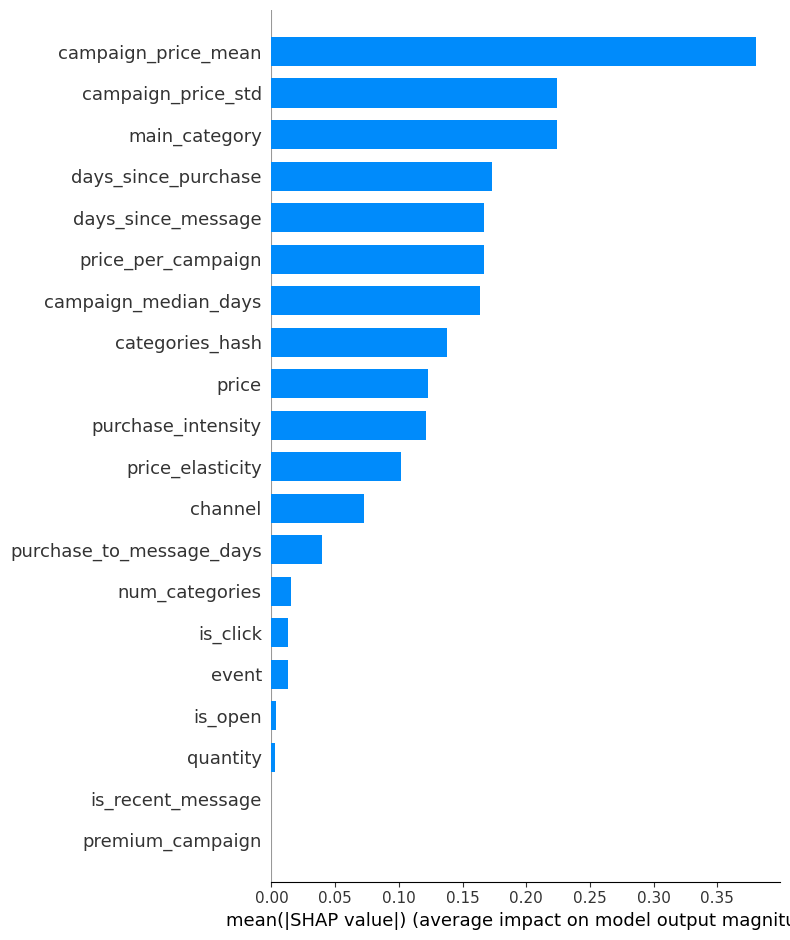

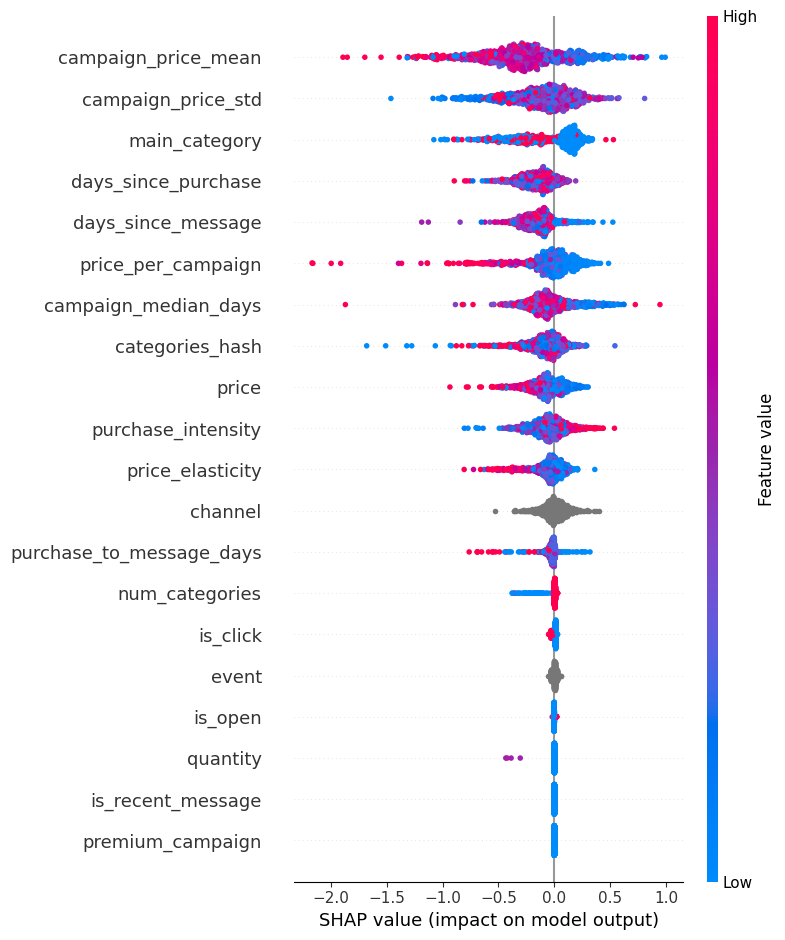

In [42]:
print("\n=== SHAP Analysis ===")
explainer = shap.TreeExplainer(model)
X_sample = X_train.sample(n=min(1000, len(X_train)), random_state=42)
shap_values = explainer.shap_values(X_sample)

# –ë–∞—Ä–ø–ª–æ—Ç
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=True)

# –†–∞—Å—Å–µ—è–Ω–∏–µ
shap.summary_plot(shap_values, X_sample, show=True)


---

### üìà –í—ã–≤–æ–¥ –ø–æ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º SHAP-–∞–Ω–∞–ª–∏–∑a –≤–∞–∂–Ω–æ—Å—Ç–∏ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤

–ê–Ω–∞–ª–∏–∑ –≤–ª–∏—è–Ω–∏—è –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –º–æ–¥–µ–ª–∏ –º–∞—à–∏–Ω–Ω–æ–≥–æ –æ–±—É—á–µ–Ω–∏—è —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º SHAP (SHapley Additive ExPlanations) –ø–æ–∑–≤–æ–ª–∏–ª –≤—ã—è–≤–∏—Ç—å –∫–ª—é—á–µ–≤—ã–µ —Ñ–∞–∫—Ç–æ—Ä—ã, –≤–ª–∏—è—é—â–∏–µ –Ω–∞ –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å –æ—Ç–∫–ª–∏–∫–∞ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è –Ω–∞ –º–∞—Ä–∫–µ—Ç–∏–Ω–≥–æ–≤—É—é –∫–∞–º–ø–∞–Ω–∏—é.

#### üîù –û—Å–Ω–æ–≤–Ω—ã–µ —Ñ–∞–∫—Ç–æ—Ä—ã, —É–≤–µ–ª–∏—á–∏–≤–∞—é—â–∏–µ –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å –æ—Ç–∫–ª–∏–∫–∞:

1. **–ù–∏–∑–∫–∞—è —Å—Ä–µ–¥–Ω—è—è —Ü–µ–Ω–∞ –∫–∞–º–ø–∞–Ω–∏–∏ (`campaign_price_mean`)** ‚Äî –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–∏ —á–∞—â–µ –æ—Ç–∫–ª–∏–∫–∞—é—Ç—Å—è –Ω–∞ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è —Å –Ω–∏–∑–∫–æ–π —Å—Ç–æ–∏–º–æ—Å—Ç—å—é.
2. **–ù–∏–∑–∫–æ–µ —Å—Ç–∞–Ω–¥–∞—Ä—Ç–Ω–æ–µ –æ—Ç–∫–ª–æ–Ω–µ–Ω–∏–µ —Ü–µ–Ω (`campaign_price_std`)** ‚Äî –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è —Å –æ–¥–∏–Ω–∞–∫–æ–≤—ã–º–∏ –∏–ª–∏ —Å—Ç–∞–±–∏–ª—å–Ω–æ –Ω–∏–∑–∫–∏–º–∏ —Ü–µ–Ω–∞–º–∏ –≤—ã–∑—ã–≤–∞—é—Ç –±–æ–ª—å—à–µ –¥–æ–≤–µ—Ä–∏—è –∏ –∏–Ω—Ç–µ—Ä–µ—Å–∞.
3. **–í—ã—Å–æ–∫–∞—è —ç–ª–∞—Å—Ç–∏—á–Ω–æ—Å—Ç—å —Ü–µ–Ω—ã (`price_elasticity`)** ‚Äî –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–∏, —á—É–≤—Å—Ç–≤–∏—Ç–µ–ª—å–Ω—ã–µ –∫ —Ü–µ–Ω–µ, —Å –±–æ–ª—å—à–µ–π –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å—é —Ä–µ–∞–≥–∏—Ä—É—é—Ç –Ω–∞ –∞–∫—Ü–∏–∏.
4. **–ù–µ–¥–∞–≤–Ω–∏–µ –∫–æ–Ω—Ç–∞–∫—Ç—ã (`days_since_message`, `days_since_purchase`)** ‚Äî —á–µ–º –º–µ–Ω—å—à–µ –≤—Ä–µ–º–µ–Ω–∏ –ø—Ä–æ—à–ª–æ —Å –º–æ–º–µ–Ω—Ç–∞ –ø–æ—Å–ª–µ–¥–Ω–µ–≥–æ –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏—è –∏–ª–∏ –ø–æ–∫—É–ø–∫–∏, —Ç–µ–º –≤—ã—à–µ –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å –æ—Ç–∫–ª–∏–∫–∞.

#### ‚ùå –§–∞–∫—Ç–æ—Ä—ã, —Å–Ω–∏–∂–∞—é—â–∏–µ –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å –æ—Ç–∫–ª–∏–∫–∞:

1. **–í—ã—Å–æ–∫–∞—è —Å—Ä–µ–¥–Ω—è—è —Ü–µ–Ω–∞** ‚Äî –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–∏ –∏–≥–Ω–æ—Ä–∏—Ä—É—é—Ç –¥–æ—Ä–æ–≥–∏–µ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è.
2. **–î–æ–ª–≥–∏–π –ø–µ—Ä–µ—Ä—ã–≤ —Å –º–æ–º–µ–Ω—Ç–∞ –ø–æ—Å–ª–µ–¥–Ω–µ–≥–æ —Å–æ–æ–±—â–µ–Ω–∏—è** ‚Äî –µ—Å–ª–∏ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—å –¥–∞–≤–Ω–æ –Ω–µ –ø–æ–ª—É—á–∞–ª –∫–æ–º–º—É–Ω–∏–∫–∞—Ü–∏–∏, –∏–Ω—Ç–µ—Ä–µ—Å –∫ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è–º —Å–Ω–∏–∂–∞–µ—Ç—Å—è.
3. **–ë–æ–ª—å—à–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –¥–Ω–µ–π —Å –º–æ–º–µ–Ω—Ç–∞ –ø–æ—Å–ª–µ–¥–Ω–µ–π –ø–æ–∫—É–ø–∫–∏** ‚Äî –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–∏ —Ç–µ—Ä—è—é—Ç –∞–∫—Ç—É–∞–ª—å–Ω–æ—Å—Ç—å –∫ –ø—Ä–æ–¥—É–∫—Ç—É.

#### üß† –î—Ä—É–≥–∏–µ –≤–∞–∂–Ω—ã–µ –Ω–∞–±–ª—é–¥–µ–Ω–∏—è:

* **–¢–∏–ø –∫–∞—Ç–µ–≥–æ—Ä–∏–∏ (`main_category`, `categories_hash`)** –∏–≥—Ä–∞–µ—Ç –∑–Ω–∞—á–∏–º—É—é —Ä–æ–ª—å ‚Äî –æ–ø—Ä–µ–¥–µ–ª—ë–Ω–Ω—ã–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–∏ —Ç–æ–≤–∞—Ä–æ–≤ –≤—ã–∑—ã–≤–∞—é—Ç –±–æ–ª—å—à–µ –∏–Ω—Ç–µ—Ä–µ—Å–∞.
* **–ò–Ω—Ç–µ–Ω—Å–∏–≤–Ω–æ—Å—Ç—å –ø–æ–∫—É–ø–æ–∫ (`purchase_intensity`)** ‚Äî –∞–∫—Ç–∏–≤–Ω—ã–µ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–∏ –±–æ–ª–µ–µ —Å–∫–ª–æ–Ω–Ω—ã –∫ –ø–æ–≤—Ç–æ—Ä–Ω—ã–º –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏—è–º.
* **–ö–∞–Ω–∞–ª –∫–æ–º–º—É–Ω–∏–∫–∞—Ü–∏–∏ (`channel`)** —Ç–æ–∂–µ –≤–ª–∏—è–µ—Ç, —Ö–æ—Ç—è –∏ —Å–ª–∞–±–µ–µ ‚Äî —Å—Ç–æ–∏—Ç –ø—Ä–æ—Ç–µ—Å—Ç–∏—Ä–æ–≤–∞—Ç—å –Ω–∞–∏–±–æ–ª–µ–µ —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω—ã–µ.

---

### ‚úÖ –†–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏:

1. **–°–µ–≥–º–µ–Ω—Ç–∏—Ä–æ–≤–∞—Ç—å –∞—É–¥–∏—Ç–æ—Ä–∏—é –ø–æ —á—É–≤—Å—Ç–≤–∏—Ç–µ–ª—å–Ω–æ—Å—Ç–∏ –∫ —Ü–µ–Ω–µ –∏ –≤—Ä–µ–º–µ–Ω–∏ –æ—Ç–∫–ª–∏–∫–∞** ‚Äî –∞–¥–∞–ø—Ç–∏—Ä–æ–≤–∞—Ç—å –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è –∏ —Å—Ä–æ–∫–∏ —Ä–∞—Å—Å—ã–ª–∫–∏.
2. **–§–æ–∫—É—Å–∏—Ä–æ–≤–∞—Ç—å—Å—è –Ω–∞ –∞–∫—Ç—É–∞–ª—å–Ω—ã—Ö, –¥–µ—à—ë–≤—ã—Ö –∏ –æ–¥–Ω–æ—Ä–æ–¥–Ω—ã—Ö –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è—Ö** ‚Äî –æ–Ω–∏ –Ω–∞–∏–±–æ–ª–µ–µ —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω—ã.
3. **–ü–µ—Ä–∏–æ–¥–∏—á–µ—Å–∫–∏ –Ω–∞–ø–æ–º–∏–Ω–∞—Ç—å –æ —Å–µ–±–µ –∞–∫—Ç–∏–≤–Ω—ã–º –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è–º** ‚Äî –æ—Å–æ–±–µ–Ω–Ω–æ –≤ –ø–µ—Ä–≤—ã–µ –¥–Ω–∏ –ø–æ—Å–ª–µ –ø–æ—Å–ª–µ–¥–Ω–µ–π –ø–æ–∫—É–ø–∫–∏ –∏–ª–∏ –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏—è.

---

